In [1]:
import os
import datetime
import gc

def timestamp():
    print(datetime.datetime.now().strftime("%b %d %Y, %H:%M:%S"))

# Training

In [2]:
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Trainer

C:\Users\Kevin\miniconda3\envs\ir\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
maxsteps = 400000
use_full_dataset = False

maxsteps_str=f"{maxsteps:,}".replace(',','.')
extra_experiment_name = '_l1_mean_5e-3'
experiment = f"msmarco_{maxsteps_str}{extra_experiment_name}"
triples= r"../data/triples.train.small.id.json"

if use_full_dataset:
    experiment += "_full"
    triples=r"../data/triples.train.full.id.json"
    
config = ColBERTConfig(
        bsize=64,
        root=fr"experiments/{experiment}",
        maxsteps=maxsteps,
        experiment=experiment,
        name=experiment,
    
        triples=triples,
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.train.tsv",
        
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

config

ColBERTConfig(ncells=None, centroid_score_threshold=None, ndocs=None, index_path=None, nbits=1, kmeans_niters=4, resume=False, similarity='cosine', bsize=64, accumsteps=1, lr=3e-06, maxsteps=400000, save_every=None, warmup=None, warmup_bert=None, relu=False, nway=2, use_ib_negatives=False, reranker=False, distillation_alpha=1.0, ignore_scores=False, query_maxlen=32, attend_to_mask_tokens=False, interaction='colbert', dim=128, doc_maxlen=220, mask_punctuation=True, checkpoint=None, triples='../data/triples.train.small.id.json', collection='../data/collection.tsv', queries='../data/queries.train.tsv', index_name=None, overwrite=False, root='experiments/msmarco_400.000_l1_mean_5e-3', experiment='msmarco_400.000_l1_mean_5e-3', index_root=None, name='msmarco_400.000_l1_mean_5e-3', rank=0, nranks=1, amp=True, gpus=1)

In [ ]:
timestamp()
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    trainer = Trainer(
        triples= config.triples,
        queries= config.queries,
        collection= config.collection,
        config=config,
    )

    checkpoint_path = trainer.train()

    print(f"Saved checkpoint to {checkpoint_path}...")
timestamp()

Nov 27 2022, 03:32:18
#> Starting...


In [ ]:
del trainer

# Indexing

In [10]:
import datetime
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer

In [8]:
nbits = 2
maxsteps = 400000
use_iter = 400000
prune_amount = 0.0
prune_type = 'attention_no_dense'

maxsteps_str=f"{maxsteps:,}".replace(',','.')
extra_experiment_name = '_l1_mean_1e-5'
experiment = f"msmarco_{maxsteps_str}{extra_experiment_name}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if prune_amount > 0:
    checkpoint = f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}"
    index_name = f"{index_name}.prune={prune_amount}.prune_type={prune_type}"

if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"
    print(f"Couldn't find checkpoint. Using default checkpoint: {checkpoint}")
    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.train.tsv",
    
        checkpoint=checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )
config

ColBERTConfig(ncells=None, centroid_score_threshold=None, ndocs=None, index_path='experiments/msmarco_400.000_l1_mean_1e-5/indexes/msmarco_400.000.nbits=2', nbits=2, kmeans_niters=4, resume=False, similarity='cosine', bsize=64, accumsteps=1, lr=3e-06, maxsteps=500000, save_every=None, warmup=None, warmup_bert=None, relu=False, nway=2, use_ib_negatives=False, reranker=False, distillation_alpha=1.0, ignore_scores=False, query_maxlen=32, attend_to_mask_tokens=False, interaction='colbert', dim=128, doc_maxlen=220, mask_punctuation=True, checkpoint='experiments/msmarco_400.000_l1_mean_1e-5/checkpoints/colbert-400000', triples='../data/triples.train.small.id.json', collection='../data/collection.tsv', queries='../data/queries.train.tsv', index_name='msmarco_400.000.nbits=2', overwrite='resume', root='experiments/msmarco_400.000_l1_mean_1e-5', experiment='msmarco_400.000_l1_mean_1e-5', index_root=None, name='msmarco_400.000_l1_mean_1e-5', rank=0, nranks=1, amp=True, gpus=1)

In [11]:
timestamp()
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    indexer = Indexer(checkpoint=config.checkpoint, config=config)
    indexer.index(name=config.index_name, collection=config.collection, overwrite=config.overwrite)
timestamp()

Nov 26 2022, 20:19:57


[Nov 26, 20:19:57] #> Creating directory experiments/msmarco_400.000_l1_mean_1e-5/indexes/msmarco_400.000.nbits=2 


#> Starting...
#> Joined...
Nov 27 2022, 00:28:03


In [13]:
del indexer
gc.collect()

477

# Retrieval

In [15]:
from colbert.data import Queries
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher

import os

In [12]:
nbits = 2
maxsteps = 400000
use_iter = 400000
prune_amount = 0.0
prune_type = 'dense'
k = 1000


maxsteps_str=f"{maxsteps:,}".replace(',','.')
extra_experiment_name = '_l1_mean_1e-5'

experiment = f"msmarco_{maxsteps_str}{extra_experiment_name}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 

if prune_amount > 0:
    checkpoint = f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}"
    index_name = f"{index_name}.prune={prune_amount}.prune_type={prune_type}"

    
if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"
    print(f"Couldn't find checkpoint. Using default checkpoint: {checkpoint}")


    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.dev_clean.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

In [16]:
timestamp()

with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)
    queries = Queries(config.queries)
    ranking = searcher.search_all(queries, k=k)
    ranking.save(f"msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv")
timestamp()

Nov 27 2022, 00:30:43
[Nov 27, 00:30:43] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 
[Nov 27, 00:31:03] #> Loading codec...
[Nov 27, 00:31:03] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Nov 27, 00:31:14] #> Loading IVF...
[Nov 27, 00:31:15] #> Loading doclens...


100%|████████████████████████████████████| 354/354 [00:00<00:00, 644.81it/s]


[Nov 27, 00:31:16] #> Loading codes and residuals...


100%|█████████████████████████████████████| 354/354 [00:09<00:00, 36.22it/s]

[Nov 27, 00:31:26] #> Loading the queries from ../data/queries.dev_clean.tsv ...
[Nov 27, 00:31:26] #> Got 55578 queries. All QIDs are unique.




100%|█████████████████████████████████| 55578/55578 [32:47<00:00, 28.24it/s]




[Nov 27, 01:04:41] #> Creating directory D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_400.000_l1_mean_1e-5\retrieval 


[Nov 27, 01:06:46] #> Saved ranking of 55578 queries and 55578000 lines to D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_400.000_l1_mean_1e-5\retrieval\msmarco.400.000.nbits=2.prune=0.0.prune_type=dense.ranking=1000.tsv
Nov 27 2022, 01:06:46


In [20]:
del searcher, queries, ranking
gc.collect()

1800

# Evaluate

In [23]:
!python -m utility.evaluate.msmarco_passages \
--ranking "experiments/{experiment}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv" \
--qrels "../data/qrels.dev.tsv" > "experiments/{experiment}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv.log"


  0%|          | 0/1.1459598541259766 [00:00<?, ?MiB/s]
 73%|#######2  | 0.8359508514404297/1.1459598541259766 [00:00<00:00,  8.36MiB/s]
 95%|#########5| 1.089432716369629/1.1459598541259766 [00:00<00:00,  9.04MiB/s] 

  0%|          | 0/1564.3835706710815 [00:00<?, ?MiB/s]
  0%|          | 1.4815292358398438/1564.3835706710815 [00:00<01:46, 14.74MiB/s]
  0%|          | 3.0417890548706055/1564.3835706710815 [00:00<01:42, 15.25MiB/s]
  0%|          | 4.584056854248047/1564.3835706710815 [00:00<01:41, 15.29MiB/s] 
  0%|          | 6.150958061218262/1564.3835706710815 [00:00<01:41, 15.41MiB/s]
  0%|          | 7.692021369934082/1564.3835706710815 [00:00<01:42, 15.19MiB/s]
  1%|          | 9.238273620605469/1564.3835706710815 [00:00<01:41, 15.26MiB/s]
  1%|          | 10.793148040771484/1564.3835706710815 [00:00<01:41, 15.35MiB/s]
  1%|          | 12.353870391845703/1564.3835706710815 [00:00<01:40, 15.41MiB/s]
  1%|          | 13.915000915527344/1564.3835706710815 [00:00<01:40, 15.47MiB/s

# Pull Stats

In [129]:
import re
import os
import pandas as pd

In [138]:
all_model_results = []
for file_path, file_name in [(x.path, x.name) for x in os.scandir(r"experiments\msmarco_500.000\retrieval") if x.name.endswith("log")]:    
    model_param = {}
    model_step = ""
    for data in re.split(r'(?<=[0-9])\.(?=[^0-9])|(?<=[a-z])\.(?=[^0-9])', file_name):
        if "=" in data:
            data_split = data.split("=")
            model_param[data_split[0]] = data_split[1]
        elif 'msmarco' in data:
            model_param['num_steps'] = "".join(data.split(".")[1:])

    with open(file_path, "r") as file:
        results = file.readlines()

    model_metrics = {}
    for m in [x for x in results if ("MRR@" in x or "Recall@" in x) and "only for ranked" not in x and "=" in x]:
        key, val = m.split("#>")[-1].split("=")
        model_metrics[key.strip()] = float(val)
    model_param.update(model_metrics)
    all_model_results.append(model_param)

In [139]:
df = pd.DataFrame(all_model_results)
df.prune.fillna(0, inplace=True)
df.sample(3)

,num_steps,nbits,prune,prune_type,ranking,MRR@10,Recall@50,Recall@100,Recall@200,Recall@1000
10,400000,2,0,NaN,1000,0.357418,0.807960,0.859794,0.895890,0.930948
0,400000,2,0.05,all,1000,0.358203,0.808322,0.860623,0.896464,0.931849
11,500000,1,0,NaN,100,0.346165,0.779313,0.825859,NaN,NaN


In [140]:
df.groupby(['num_steps','nbits','prune','prune_type'], dropna=False).first()

ranking    MRR@10  Recall@50  \
num_steps nbits prune prune_type                                        
400000    2     0     NaN                   1000  0.357418   0.807960   
                0.05  all                   1000  0.358203   0.808322   
                      attention             1000  0.357817   0.808489   
                      attention_no_dense    1000  0.358013   0.808478   
                      dense                 1000  0.357605   0.809286   
                0.1   all                   1000  0.357874   0.809031   
                      attention             1000  0.358179   0.809066   
                      attention_no_dense    1000  0.358903   0.809645   
                      dense                 1000  0.357383   0.809241   
                0.15  dense                 1000  0.356099   0.805613   
                0.2   dense                 1000  0.356519   0.805899   
500000    1     0     NaN                    100  0.346165   0.779313   
          2     0     NaN                    100  0.351166   0.782316   
80000     2     0     NaN                    100  0.354836   0.813706   

                                          Recall@100  Recall@200  Recall@1000  
num_steps nbits prune prune_type                                               
400000    2     0     NaN                   0.859794    0.895890     0.930948  
                0.05  all                   0.860623    0.896464     0.931849  
                      attention             0.860506    0.896285     0.931527  
                      attention_no_dense    0.860494    0.896483     0.931539  
                      dense                 0.860347    0.896690     0.932399  
                0.1   all                   0.860841    0.896269     0.932229  
                      attention             0.861275    0.897166     0.932763  
                      attention_no_dense    0.861907    0.897481     0.933289  
                      dense                 0.860656    0.896527     0.932206  
                0.15  dense                 0.857697    0.894434     0.929234  
                0.2   dense                 0.856858    0.892856     0.928800  
500000    1     0     NaN                   0.825859         NaN          NaN  
          2     0     NaN                   0.827102         NaN          NaN  
80000     2     0     NaN                   0.861810         NaN          NaN

In [141]:
df.groupby(['num_steps','nbits','prune_type','prune'], dropna=False).first()

ranking    MRR@10  Recall@50  \
num_steps nbits prune_type         prune                                
400000    2     all                0.05     1000  0.358203   0.808322   
                                   0.1      1000  0.357874   0.809031   
                attention          0.05     1000  0.357817   0.808489   
                                   0.1      1000  0.358179   0.809066   
                attention_no_dense 0.05     1000  0.358013   0.808478   
                                   0.1      1000  0.358903   0.809645   
                dense              0.05     1000  0.357605   0.809286   
                                   0.1      1000  0.357383   0.809241   
                                   0.15     1000  0.356099   0.805613   
                                   0.2      1000  0.356519   0.805899   
                NaN                0        1000  0.357418   0.807960   
500000    1     NaN                0         100  0.346165   0.779313   
          2     NaN                0         100  0.351166   0.782316   
80000     2     NaN                0         100  0.354836   0.813706   

                                          Recall@100  Recall@200  Recall@1000  
num_steps nbits prune_type         prune                                       
400000    2     all                0.05     0.860623    0.896464     0.931849  
                                   0.1      0.860841    0.896269     0.932229  
                attention          0.05     0.860506    0.896285     0.931527  
                                   0.1      0.861275    0.897166     0.932763  
                attention_no_dense 0.05     0.860494    0.896483     0.931539  
                                   0.1      0.861907    0.897481     0.933289  
                dense              0.05     0.860347    0.896690     0.932399  
                                   0.1      0.860656    0.896527     0.932206  
                                   0.15     0.857697    0.894434     0.929234  
                                   0.2      0.856858    0.892856     0.928800  
                NaN                0        0.859794    0.895890     0.930948  
500000    1     NaN                0        0.825859         NaN          NaN  
          2     NaN                0        0.827102         NaN          NaN  
80000     2     NaN                0        0.861810         NaN          NaN

# Prune Model

In [24]:
import os
from colbert.modeling.colbert import colbert_score
from colbert.modeling.checkpoint import Checkpoint
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
import torch
from tqdm.auto import tqdm
import torch.nn.utils.prune as prune
import re
import gc

In [25]:
def filter_layers(name, prune_type, ignore_bias=True):
    if name.startswith('model.bert.embeddings') \
        or 'LayerNorm' in name: 
            return True
    if ignore_bias and name.endswith('bias'):
        return True
    if prune_type == "dense":
        if "attention" in name:
            return True
    elif "attention" in prune_type:
        if "attention" not in name:
            return True
        if "no_dense" in prune_type and "dense" in name:
            return True
    return False

In [3]:
use_full_data = True
nbits = 2
maxsteps = 400000
use_iter = 400000
prune_amount = 0.20

maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"
if use_full_data:
    experiment += f".data=full"

base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if not os.path.exists(checkpoint):
        checkpoint = fr"{base_path}/checkpoints/colbert"
        print(f"Couldn't find checkpoint. Using default checkpoint: {checkpoint}")

    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.dev.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        ncells= 10,
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

In [28]:
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    model = Checkpoint(config.checkpoint, colbert_config=config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Checkpoint(
  (model): HF_ColBERT(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (La

In [29]:
import numpy as np 

In [8]:
prune_type = 'attention'

In [9]:
np.sum([p.abs().sum().cpu().detach().numpy() 
                    for name, p in model.named_parameters() 
                    if not filter_layers(name, prune_type)])

852849.4

In [25]:
np.mean([p.abs().sum().cpu().detach().numpy() 
                    for name, p in model.named_parameters() 
                    if not filter_layers(name, prune_type)])

17767.695

In [9]:
17767.695 * 1e-5

0.17767695

In [44]:
for prune_type in ["dense", "attention", "attention_no_dense", "all"]:
    with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
        model = Checkpoint(config.checkpoint, colbert_config=config)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
        
    parameters_to_prune = []
    for name, param in tqdm(model.named_parameters()):
        if filter_layers(name, prune_type): continue
        sparsity = 100. * float(torch.sum(param == 0))/ float(param.nelement())
        clean_name = re.sub(r"\.(\d+)", r"[\1]", name.replace('.weight', ''))
        parameters_to_prune.append((eval(clean_name), 'weight'))
        print(f"({clean_name}")
    parameters_to_prune = tuple(parameters_to_prune)


    print(f"pruning model to: {prune_amount}")
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_amount
    )
    # save pruned model
    for layer, _ in parameters_to_prune:
        prune.remove(layer, 'weight')
    # if not ignore_bias:
    #     prune_type += "-bias"
    model.save(f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}")
    del model
    gc.collect()


200it [00:00, 17376.71it/s]


(model.bert.encoder.layer[0].intermediate.dense
(model.bert.encoder.layer[0].output.dense
(model.bert.encoder.layer[1].intermediate.dense
(model.bert.encoder.layer[1].output.dense
(model.bert.encoder.layer[2].intermediate.dense
(model.bert.encoder.layer[2].output.dense
(model.bert.encoder.layer[3].intermediate.dense
(model.bert.encoder.layer[3].output.dense
(model.bert.encoder.layer[4].intermediate.dense
(model.bert.encoder.layer[4].output.dense
(model.bert.encoder.layer[5].intermediate.dense
(model.bert.encoder.layer[5].output.dense
(model.bert.encoder.layer[6].intermediate.dense
(model.bert.encoder.layer[6].output.dense
(model.bert.encoder.layer[7].intermediate.dense
(model.bert.encoder.layer[7].output.dense
(model.bert.encoder.layer[8].intermediate.dense
(model.bert.encoder.layer[8].output.dense
(model.bert.encoder.layer[9].intermediate.dense
(model.bert.encoder.layer[9].output.dense
(model.bert.encoder.layer[10].intermediate.dense
(model.bert.encoder.layer[10].output.dense
(model.b


200it [00:00, 7993.03it/s]


(model.bert.encoder.layer[0].attention.self.query
(model.bert.encoder.layer[0].attention.self.key
(model.bert.encoder.layer[0].attention.self.value
(model.bert.encoder.layer[0].attention.output.dense
(model.bert.encoder.layer[1].attention.self.query
(model.bert.encoder.layer[1].attention.self.key
(model.bert.encoder.layer[1].attention.self.value
(model.bert.encoder.layer[1].attention.output.dense
(model.bert.encoder.layer[2].attention.self.query
(model.bert.encoder.layer[2].attention.self.key
(model.bert.encoder.layer[2].attention.self.value
(model.bert.encoder.layer[2].attention.output.dense
(model.bert.encoder.layer[3].attention.self.query
(model.bert.encoder.layer[3].attention.self.key
(model.bert.encoder.layer[3].attention.self.value
(model.bert.encoder.layer[3].attention.output.dense
(model.bert.encoder.layer[4].attention.self.query
(model.bert.encoder.layer[4].attention.self.key
(model.bert.encoder.layer[4].attention.self.value
(model.bert.encoder.layer[4].attention.output.dense



200it [00:00, 23512.65it/s]


(model.bert.encoder.layer[0].attention.self.query
(model.bert.encoder.layer[0].attention.self.key
(model.bert.encoder.layer[0].attention.self.value
(model.bert.encoder.layer[1].attention.self.query
(model.bert.encoder.layer[1].attention.self.key
(model.bert.encoder.layer[1].attention.self.value
(model.bert.encoder.layer[2].attention.self.query
(model.bert.encoder.layer[2].attention.self.key
(model.bert.encoder.layer[2].attention.self.value
(model.bert.encoder.layer[3].attention.self.query
(model.bert.encoder.layer[3].attention.self.key
(model.bert.encoder.layer[3].attention.self.value
(model.bert.encoder.layer[4].attention.self.query
(model.bert.encoder.layer[4].attention.self.key
(model.bert.encoder.layer[4].attention.self.value
(model.bert.encoder.layer[5].attention.self.query
(model.bert.encoder.layer[5].attention.self.key
(model.bert.encoder.layer[5].attention.self.value
(model.bert.encoder.layer[6].attention.self.query
(model.bert.encoder.layer[6].attention.self.key
(model.bert.en


0it [00:00, ?it/s]
200it [00:00, 1306.14it/s]A


(model.bert.encoder.layer[0].attention.self.query
(model.bert.encoder.layer[0].attention.self.key
(model.bert.encoder.layer[0].attention.self.value
(model.bert.encoder.layer[0].attention.output.dense
(model.bert.encoder.layer[0].intermediate.dense
(model.bert.encoder.layer[0].output.dense
(model.bert.encoder.layer[1].attention.self.query
(model.bert.encoder.layer[1].attention.self.key
(model.bert.encoder.layer[1].attention.self.value
(model.bert.encoder.layer[1].attention.output.dense
(model.bert.encoder.layer[1].intermediate.dense
(model.bert.encoder.layer[1].output.dense
(model.bert.encoder.layer[2].attention.self.query
(model.bert.encoder.layer[2].attention.self.key
(model.bert.encoder.layer[2].attention.self.value
(model.bert.encoder.layer[2].attention.output.dense
(model.bert.encoder.layer[2].intermediate.dense
(model.bert.encoder.layer[2].output.dense
(model.bert.encoder.layer[3].attention.self.query
(model.bert.encoder.layer[3].attention.self.key
(model.bert.encoder.layer[3].att

# Check Module Prune

In [30]:
# recheck saved pruned model sparity
for prune_type in ["dense", "attention", "attention_no_dense", "all"]:
    # prune_ckp = f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}"
    # with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    #     model = Checkpoint(prune_ckp, colbert_config=config)

    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.to(device)
    
    print(prune_type)
    sparse_count, total_count = 0,0
    for name, param in tqdm(model.named_parameters()):
        if filter_layers(name, prune_type): continue
        sparse_count += torch.sum(param == 0)
        total_count += param.nelement()
        sparsity = 100. * float(torch.sum(param == 0))/ float(param.nelement())
        layer_min_val = param.abs().min()
        print(name, sparsity, layer_min_val)
    print(f"overal sparsity:", 100. * float(sparse_count/total_count))
    print('-'*50)
# del model
# gc.collect()

dense


200it [00:00, 1219.51it/s]


model.bert.encoder.layer.0.intermediate.dense.weight 0.0
model.bert.encoder.layer.0.output.dense.weight 0.0
model.bert.encoder.layer.1.intermediate.dense.weight 0.0
model.bert.encoder.layer.1.output.dense.weight 0.0
model.bert.encoder.layer.2.intermediate.dense.weight 0.0
model.bert.encoder.layer.2.output.dense.weight 0.0
model.bert.encoder.layer.3.intermediate.dense.weight 0.0
model.bert.encoder.layer.3.output.dense.weight 0.0
model.bert.encoder.layer.4.intermediate.dense.weight 0.0
model.bert.encoder.layer.4.output.dense.weight 0.0
model.bert.encoder.layer.5.intermediate.dense.weight 0.0
model.bert.encoder.layer.5.output.dense.weight 0.0
model.bert.encoder.layer.6.intermediate.dense.weight 0.0
model.bert.encoder.layer.6.output.dense.weight 0.0
model.bert.encoder.layer.7.intermediate.dense.weight 0.0
model.bert.encoder.layer.7.output.dense.weight 0.0
model.bert.encoder.layer.8.intermediate.dense.weight 0.0
model.bert.encoder.layer.8.output.dense.weight 0.0
model.bert.encoder.layer.9.i

0it [00:00, ?it/s]

model.bert.encoder.layer.0.attention.self.query.weight 0.0
model.bert.encoder.layer.0.attention.self.key.weight 0.0
model.bert.encoder.layer.0.attention.self.value.weight 0.0
model.bert.encoder.layer.0.attention.output.dense.weight 0.0
model.bert.encoder.layer.1.attention.self.query.weight 0.0
model.bert.encoder.layer.1.attention.self.key.weight 0.0
model.bert.encoder.layer.1.attention.self.value.weight 0.0
model.bert.encoder.layer.1.attention.output.dense.weight 0.0
model.bert.encoder.layer.2.attention.self.query.weight 0.0
model.bert.encoder.layer.2.attention.self.key.weight 0.0
model.bert.encoder.layer.2.attention.self.value.weight 0.0
model.bert.encoder.layer.2.attention.output.dense.weight 0.0
model.bert.encoder.layer.3.attention.self.query.weight 0.0
model.bert.encoder.layer.3.attention.self.key.weight 0.0
model.bert.encoder.layer.3.attention.self.value.weight 0.0
model.bert.encoder.layer.3.attention.output.dense.weight 0.0
model.bert.encoder.layer.4.attention.self.query.weight 0

200it [00:00, 3389.93it/s]


model.bert.encoder.layer.6.attention.self.query.weight 0.0
model.bert.encoder.layer.6.attention.self.key.weight 0.0
model.bert.encoder.layer.6.attention.self.value.weight 0.0
model.bert.encoder.layer.6.attention.output.dense.weight 0.0
model.bert.encoder.layer.7.attention.self.query.weight 0.0
model.bert.encoder.layer.7.attention.self.key.weight 0.0
model.bert.encoder.layer.7.attention.self.value.weight 0.0
model.bert.encoder.layer.7.attention.output.dense.weight 0.0
model.bert.encoder.layer.8.attention.self.query.weight 0.0
model.bert.encoder.layer.8.attention.self.key.weight 0.0
model.bert.encoder.layer.8.attention.self.value.weight 0.0
model.bert.encoder.layer.8.attention.output.dense.weight 0.0
model.bert.encoder.layer.9.attention.self.query.weight 0.0
model.bert.encoder.layer.9.attention.self.key.weight 0.0
model.bert.encoder.layer.9.attention.self.value.weight 0.0
model.bert.encoder.layer.9.attention.output.dense.weight 0.0
model.bert.encoder.layer.10.attention.self.query.weight 

200it [00:00, 7407.29it/s]


model.bert.encoder.layer.0.attention.self.query.weight 0.0
model.bert.encoder.layer.0.attention.self.key.weight 0.0
model.bert.encoder.layer.0.attention.self.value.weight 0.0
model.bert.encoder.layer.1.attention.self.query.weight 0.0
model.bert.encoder.layer.1.attention.self.key.weight 0.0
model.bert.encoder.layer.1.attention.self.value.weight 0.0
model.bert.encoder.layer.2.attention.self.query.weight 0.0
model.bert.encoder.layer.2.attention.self.key.weight 0.0
model.bert.encoder.layer.2.attention.self.value.weight 0.0
model.bert.encoder.layer.3.attention.self.query.weight 0.0
model.bert.encoder.layer.3.attention.self.key.weight 0.0
model.bert.encoder.layer.3.attention.self.value.weight 0.0
model.bert.encoder.layer.4.attention.self.query.weight 0.0
model.bert.encoder.layer.4.attention.self.key.weight 0.0
model.bert.encoder.layer.4.attention.self.value.weight 0.0
model.bert.encoder.layer.5.attention.self.query.weight 0.0
model.bert.encoder.layer.5.attention.self.key.weight 0.0
model.ber

200it [00:00, 11766.38it/s]

model.bert.encoder.layer.0.attention.self.query.weight 0.0
model.bert.encoder.layer.0.attention.self.key.weight 0.0
model.bert.encoder.layer.0.attention.self.value.weight 0.0
model.bert.encoder.layer.0.attention.output.dense.weight 0.0
model.bert.encoder.layer.0.intermediate.dense.weight 0.0
model.bert.encoder.layer.0.output.dense.weight 0.0
model.bert.encoder.layer.1.attention.self.query.weight 0.0
model.bert.encoder.layer.1.attention.self.key.weight 0.0
model.bert.encoder.layer.1.attention.self.value.weight 0.0
model.bert.encoder.layer.1.attention.output.dense.weight 0.0
model.bert.encoder.layer.1.intermediate.dense.weight 0.0
model.bert.encoder.layer.1.output.dense.weight 0.0
model.bert.encoder.layer.2.attention.self.query.weight 0.0
model.bert.encoder.layer.2.attention.self.key.weight 0.0
model.bert.encoder.layer.2.attention.self.value.weight 0.0
model.bert.encoder.layer.2.attention.output.dense.weight 0.0
model.bert.encoder.layer.2.intermediate.dense.weight 0.0
model.bert.encoder.

In [33]:
print(prune_type)
sparse_count, total_count = 0,0
for name, param in tqdm(model.named_parameters()):
    sparse_count += torch.sum(param == 0)
    total_count += param.nelement()
    sparsity = 100. * float(torch.sum(param == 0))/ float(param.nelement())
    print(name, sparsity)
print(f"overal sparsity:", 100. * float(sparse_count/total_count))
print('-'*50)

all


185it [00:00, 1047.26it/s]

model.bert.embeddings.word_embeddings.weight 0.0
model.bert.embeddings.position_embeddings.weight 0.0
model.bert.embeddings.token_type_embeddings.weight 0.0
model.bert.embeddings.LayerNorm.weight 0.0
model.bert.embeddings.LayerNorm.bias 0.0
model.bert.encoder.layer.0.attention.self.query.weight 0.0
model.bert.encoder.layer.0.attention.self.query.bias 0.0
model.bert.encoder.layer.0.attention.self.key.weight 0.0
model.bert.encoder.layer.0.attention.self.key.bias 0.0
model.bert.encoder.layer.0.attention.self.value.weight 0.0
model.bert.encoder.layer.0.attention.self.value.bias 0.0
model.bert.encoder.layer.0.attention.output.dense.weight 0.0
model.bert.encoder.layer.0.attention.output.dense.bias 0.0
model.bert.encoder.layer.0.attention.output.LayerNorm.weight 0.0
model.bert.encoder.layer.0.attention.output.LayerNorm.bias 0.0
model.bert.encoder.layer.0.intermediate.dense.weight 0.0
model.bert.encoder.layer.0.intermediate.dense.bias 0.0
model.bert.encoder.layer.0.output.dense.weight 0.0
mode

200it [00:00, 978.00it/s] 

model.bert.encoder.layer.11.attention.self.value.weight 0.0
model.bert.encoder.layer.11.attention.self.value.bias 0.0
model.bert.encoder.layer.11.attention.output.dense.weight 0.0
model.bert.encoder.layer.11.attention.output.dense.bias 0.0
model.bert.encoder.layer.11.attention.output.LayerNorm.weight 0.0
model.bert.encoder.layer.11.attention.output.LayerNorm.bias 0.0
model.bert.encoder.layer.11.intermediate.dense.weight 0.0
model.bert.encoder.layer.11.intermediate.dense.bias 0.0
model.bert.encoder.layer.11.output.dense.weight 0.0
model.bert.encoder.layer.11.output.dense.bias 0.0
model.bert.encoder.layer.11.output.LayerNorm.weight 0.0
model.bert.encoder.layer.11.output.LayerNorm.bias 0.0
model.bert.pooler.dense.weight 0.0
model.bert.pooler.dense.bias 0.0
model.linear.weight 0.0
overal sparsity: 0.0
--------------------------------------------------


# E2E: Train + Index + Retrieval + Eval

In [19]:
import datetime
import os
import gc

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Trainer, Indexer, Searcher
from colbert.data import Queries

In [20]:
do_train = False
do_index = True
do_retrieval = True
do_eval = True

In [18]:
((22*60+3)/55578)*1000 #ms

23.80438302925618

# End New

In [4]:
for prune_type in ["attention", "attention_no_dense", "dense", "all"]:
    use_full_data = True
    nbits = 2
    maxsteps = 400000
    use_iter = 400000
    prune_amount = 0.2
    k = 1000

    maxsteps_str=f"{maxsteps:,}".replace(',','.')
    experiment = f"msmarco_{maxsteps_str}"
    if use_full_data:
        experiment += f".data=full"
    
    base_path = fr"experiments/{experiment}"

    use_iter_str=f"{use_iter:,}".replace(',','.')
    index_name = f"msmarco_{use_iter_str}{'.data=full' if use_full_data else ''}.nbits={nbits}"

    checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 

    if prune_amount > 0:
        checkpoint = f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}"
        index_name = f"{index_name}.prune={prune_amount}.prune_type={prune_type}"
        
    retrieval_name = f"{index_name}.ranking={k}.tsv"

    if not os.path.exists(checkpoint):
        checkpoint = fr"{base_path}/checkpoints/colbert"
        print(f"Couldn't find checkpoint. Using default checkpoint: {checkpoint}")

    config = ColBERTConfig(
            bsize = 64,
            root=base_path,
            experiment=experiment,
            name=experiment,

            triples=r"../data/triples.train.small.id.json",
            collection= r"../data/collection.tsv",

            checkpoint=checkpoint,
            nbits=nbits,
            overwrite='resume',
            index_name=index_name,
            index_path=fr"{base_path}/indexes/{index_name}",

            rank = 0,
            nranks = 1,
            amp = True,
            gpus = 1,
        )


    if do_train:
        timestamp()
        config.set("queries", r"../data/queries.train.tsv")
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
            trainer = Trainer(
                triples= config.triples,
                queries= config.queries,
                collection= config.collection,
                config=config,
            )

            checkpoint_path = trainer.train()

            print(f"Saved checkpoint to {checkpoint_path}...")
        timestamp()

        del trainer
        gc.collect()

    if do_index:
        timestamp()
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
            indexer = Indexer(checkpoint=config.checkpoint, config=config)
            indexer.index(name=config.index_name, collection=config.collection, overwrite=config.overwrite)
        timestamp()

        del indexer
        gc.collect()

    if do_retrieval:
        timestamp()
        config.set("queries", r"../data/queries.dev_clean.tsv" 
                   if os.path.exists(r"../data/queries.dev_clean.tsv") 
                   else r"../data/queries.dev.tsv")
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
            searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)
            queries = Queries(config.queries)
            ranking = searcher.search_all(queries, k=k)
            # ranking.save(f"msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv")
            ranking.save(retrieval_name)
        timestamp()

        del searcher, queries, ranking
        gc.collect()

    if do_eval:
        # !python -m utility.evaluate.msmarco_passages \
        #     --ranking "experiments/msmarco_{maxsteps_str}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv" \
        #     --qrels "../data/qrels.dev.tsv" > "experiments/msmarco_{maxsteps_str}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv.log"
        !python -m utility.evaluate.msmarco_passages \
            --ranking "experiments/{experiment}/retrieval/{retrieval_name}" \
            --qrels "../data/qrels.dev.tsv" > "experiments/{experiment}/retrieval/{retrieval_name}.log"

Nov 22 2022, 00:58:54


[Nov 22, 00:58:54] #> Note: Output directory experiments/msmarco_400.000.data=full/indexes/msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=attention already exists


#> Starting...
#> Joined...
Nov 22 2022, 05:11:42
Nov 22 2022, 05:11:42


[Nov 22, 05:11:42] #> Creating directory experiments/msmarco_400.000.data=full/indexes/msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=attention_no_dense 


#> Starting...
#> Joined...
Nov 22 2022, 09:29:44
Nov 22 2022, 09:29:44


[Nov 22, 09:29:44] #> Creating directory experiments/msmarco_400.000.data=full/indexes/msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=dense 


#> Starting...
#> Joined...
Nov 22 2022, 14:36:39
Nov 22 2022, 14:36:39


[Nov 22, 14:36:39] #> Creating directory experiments/msmarco_400.000.data=full/indexes/msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=all 


#> Starting...
#> Joined...
Nov 22 2022, 19:19:55


In [3]:
do_train = False
do_index = False
do_retrieval =True
do_eval = True

In [6]:
for prune_type in ["attention", "attention_no_dense", "dense", "all"]:
    use_full_data = True
    nbits = 2
    maxsteps = 400000
    use_iter = 400000
    prune_amount = 0.2
    k = 1000

    maxsteps_str=f"{maxsteps:,}".replace(',','.')
    experiment = f"msmarco_{maxsteps_str}"
    if use_full_data:
        experiment += f".data=full"
    
    base_path = fr"experiments/{experiment}"

    use_iter_str=f"{use_iter:,}".replace(',','.')
    index_name = f"msmarco_{use_iter_str}{'.data=full' if use_full_data else ''}.nbits={nbits}"

    checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 

    if prune_amount > 0:
        checkpoint = f"{checkpoint}.prune={prune_amount}.prune_type={prune_type}"
        index_name = f"{index_name}.prune={prune_amount}.prune_type={prune_type}"
        
    retrieval_name = f"{index_name}.ranking={k}.tsv"

    if not os.path.exists(checkpoint):
        checkpoint = fr"{base_path}/checkpoints/colbert"
        print(f"Couldn't find checkpoint. Using default checkpoint: {checkpoint}")

    config = ColBERTConfig(
            bsize = 64,
            root=base_path,
            experiment=experiment,
            name=experiment,

            triples=r"../data/triples.train.small.id.json",
            collection= r"../data/collection.tsv",

            checkpoint=checkpoint,
            nbits=nbits,
            overwrite='resume',
            index_name=index_name,
            index_path=fr"{base_path}/indexes/{index_name}",

            rank = 0,
            nranks = 1,
            amp = True,
            gpus = 1,
        )


    if do_train:
        timestamp()
        config.set("queries", r"../data/queries.train.tsv")
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
            trainer = Trainer(
                triples= config.triples,
                queries= config.queries,
                collection= config.collection,
                config=config,
            )

            checkpoint_path = trainer.train()

            print(f"Saved checkpoint to {checkpoint_path}...")
        timestamp()

        del trainer
        gc.collect()

    if do_index:
        timestamp()
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
            indexer = Indexer(checkpoint=config.checkpoint, config=config)
            indexer.index(name=config.index_name, collection=config.collection, overwrite=config.overwrite)
        timestamp()

        del indexer
        gc.collect()

    if do_retrieval:
        timestamp()
        config.set("queries", r"../data/queries.dev_clean.tsv" 
                   if os.path.exists(r"../data/queries.dev_clean.tsv") 
                   else r"../data/queries.dev.tsv")
        with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
            searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)
            queries = Queries(config.queries)
            ranking = searcher.search_all(queries, k=k)
            # ranking.save(f"msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv")
            ranking.save(retrieval_name)
        timestamp()

        del searcher, queries, ranking
        gc.collect()

    if do_eval:
        # !python -m utility.evaluate.msmarco_passages \
        #     --ranking "experiments/msmarco_{maxsteps_str}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv" \
        #     --qrels "../data/qrels.dev.tsv" > "experiments/msmarco_{maxsteps_str}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.prune={prune_amount}.prune_type={prune_type}.ranking={k}.tsv.log"
        !python -m utility.evaluate.msmarco_passages \
            --ranking "{retrieval_name}" \
            --qrels "../data/qrels.dev.tsv" > "{retrieval_name}.log"

Nov 22 2022, 19:19:55
[Nov 22, 19:19:55] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 
[Nov 22, 19:20:17] #> Loading codec...
[Nov 22, 19:20:17] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Nov 22, 19:20:29] #> Loading IVF...
[Nov 22, 19:20:29] #> Loading doclens...


100%|████████████████████████████████████| 354/354 [00:00<00:00, 817.46it/s]


[Nov 22, 19:20:30] #> Loading codes and residuals...


100%|█████████████████████████████████████| 354/354 [00:20<00:00, 17.61it/s]

[Nov 22, 19:20:50] #> Loading the queries from ../data/queries.dev_clean.tsv ...


[Nov 22, 19:20:50] #> Got 55578 queries. All QIDs are unique.



100%|███████████████████████████████| 55578/55578 [2:44:09<00:00,  5.64it/s]




[Nov 22, 22:05:31] #> Creating directory D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_400.000.data=full\retrieval 


[Nov 22, 22:07:35] #> Saved ranking of 55578 queries and 55578000 lines to D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_400.000.data=full\retrieval\msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=attention.ranking=1000.tsv
Nov 22 2022, 22:07:35
Nov 22 2022, 22:07:47
[Nov 22, 22:07:47] #> Loading collection...
0M 


  0%|          | 0/1.1459598541259766 [00:00<?, ?MiB/s]
 60%|######    | 0.6876411437988281/1.1459598541259766 [00:00<00:00,  6.87MiB/s]
 95%|#########5| 1.089432716369629/1.1459598541259766 [00:00<00:00,  8.06MiB/s] 
Traceback (most recent call last):
  File "C:\Users\Kevin\miniconda3\envs\ir\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Kevin\miniconda3\envs\ir\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\utility\evaluate\msmarco_passages.py", line 126, in <module>
    main(args)
  File "D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\utility\evaluate\msmarco_passages.py", line 30, in main
    with open(args.ranking) as f:
FileNotFoundError: [Errno 2] No such file or directory: 'msmarco_400.000.data=full.nbits=2.prune=0.2.prune_type=attention.ranking=1000.tsv'


1M 2M 3M 4M 5M 6M 7M 8M 
[Nov 22, 22:08:09] #> Loading codec...
[Nov 22, 22:08:09] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Nov 22, 22:08:09] #> Loading IVF...
[Nov 22, 22:08:10] #> Loading doclens...


100%|████████████████████████████████████| 354/354 [00:00<00:00, 718.80it/s]


[Nov 22, 22:08:10] #> Loading codes and residuals...


100%|█████████████████████████████████████| 354/354 [00:19<00:00, 18.14it/s]

[Nov 22, 22:08:30] #> Loading the queries from ../data/queries.dev_clean.tsv ...


[Nov 22, 22:08:30] #> Got 55578 queries. All QIDs are unique.



KeyboardInterrupt: 

# Sparity

In [28]:
%load_ext autoreload
%autoreload 2

In [29]:
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher
import torch
import os
from tqdm.auto import tqdm
from collections import Counter

In [5]:
nbits = 2
maxsteps = 500000
use_iter = 400000


maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"

    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.dev.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        ncells= 10,
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

## Query

In [6]:
# encode query
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)

[Oct 31, 23:11:16] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 
[Oct 31, 23:11:40] #> Loading codec...
[Oct 31, 23:11:40] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Oct 31, 23:11:53] #> Loading IVF...
[Oct 31, 23:11:54] #> Loading doclens...


  0%|          | 0/354 [00:00<?, ?it/s]

[Oct 31, 23:11:55] #> Loading codes and residuals...


  0%|          | 0/354 [00:00<?, ?it/s]

In [16]:
f"{searcher.ranker.num_embeddings:,}"

'597,760,090'

In [6]:
life_query_encoded = searcher.encode("What is the meaning of life?")


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What is the meaning of life?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 3574, 1997, 2166, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



In [7]:
life_query_encoded.shape

torch.Size([1, 32, 128])

In [ ]:
pids, ranking, scores = searcher.search("what is the meaning of life? google") # from dev: 831190
tuple(zip(pids, ranking, scores))

((1121952, 1, 25.09375),
 (3615892, 2, 24.203125),
 (3974437, 3, 24.171875),
 (3974442, 4, 24.125),
 (8705340, 5, 23.890625),
 (7108187, 6, 23.4375),
 (4158510, 7, 23.3125),
 (342393, 8, 22.890625),
 (3456280, 9, 22.75),
 (2759560, 10, 22.734375))

In [8]:
# pids, ranking, scores = searcher.search("What is the meaning of life?")
pids, ranking, scores = searcher.dense_search(life_query_encoded)
tuple(zip(pids, ranking, scores))

((1121952, 1, 28.609375),
 (3974437, 2, 27.9375),
 (3974442, 3, 27.90625),
 (7108187, 4, 27.8125),
 (4158510, 5, 27.546875),
 (8705340, 6, 27.453125),
 (7981896, 7, 27.078125),
 (4364365, 8, 27.0625),
 (3974443, 9, 26.984375),
 (3615892, 10, 26.921875))

In [7]:
queries = Queries(config.queries)

[Oct 31, 23:21:33] #> Loading the queries from ../data/queries.dev.tsv ...
[Oct 31, 23:21:33] #> Got 101093 queries. All QIDs are unique.



In [8]:
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    queries = Queries.cast(queries)
    # queries_ = list(queries.values())
    # Q = searcher.encode(queries_)

In [107]:
# pids, length of cluster
ivf = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\ivf.pid.pt')
# float
# avg_residual = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\avg_residual.pt')
# bucket_cutoffs, bucket_weights
# buckets = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\buckets.pt')
# centroids.pt
# centroids = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\centroids.pt')

In [29]:
avg_residual

tensor(0.0453, device='cuda:0', dtype=torch.float16)

In [33]:
buckets[0].shape, buckets[1].shape, buckets

(torch.Size([3]),
 torch.Size([4]),
 (tensor([-0.0359,  0.0013,  0.0386], device='cuda:0'),
  tensor([-0.0632, -0.0161,  0.0188,  0.0662], device='cuda:0',
         dtype=torch.float16)))

In [35]:
centroids.shape, centroids

(torch.Size([262144, 128]),
 tensor([[ 0.0015, -0.1648, -0.0179,  ...,  0.0118,  0.0189, -0.0742],
         [ 0.0931, -0.1000, -0.0538,  ...,  0.0629,  0.0190,  0.0513],
         [-0.0494, -0.1044, -0.0089,  ...,  0.0700,  0.0154,  0.0945],
         ...,
         [-0.1100,  0.0224, -0.0762,  ...,  0.0764,  0.0444,  0.0469],
         [ 0.1238, -0.0312, -0.0622,  ...,  0.0558,  0.1153,  0.0131],
         [-0.0138, -0.0814,  0.0240,  ...,  0.0692,  0.1039,  0.1116]],
        device='cuda:0', dtype=torch.float16))

In [114]:
life_query_encoded.shape

torch.Size([1, 32, 128])

### Generate Candiates

In [49]:
searcher.ranker.ivf.tensor.shape

torch.Size([364665361])

In [72]:
life_query_encoded[0]

tensor([[ 0.0023,  0.0438,  0.0397,  ..., -0.0592, -0.0346,  0.0934],
        [ 0.0349,  0.0475,  0.0174,  ..., -0.0536, -0.0448,  0.1160],
        [ 0.0230,  0.0401,  0.0023,  ..., -0.0549, -0.0427,  0.1162],
        ...,
        [ 0.0634,  0.0624,  0.0376,  ..., -0.0204, -0.0386,  0.0977],
        [ 0.0428,  0.0704, -0.0031,  ..., -0.0047, -0.0438,  0.0855],
        [ 0.0010,  0.0317,  0.0723,  ...,  0.0742, -0.0945,  0.0998]],
       device='cuda:0')

In [80]:
searcher.ranker.codec.centroids

tensor([[ 0.0015, -0.1648, -0.0179,  ...,  0.0118,  0.0189, -0.0742],
        [ 0.0931, -0.1000, -0.0538,  ...,  0.0629,  0.0190,  0.0513],
        [-0.0494, -0.1044, -0.0089,  ...,  0.0700,  0.0154,  0.0945],
        ...,
        [-0.1100,  0.0224, -0.0762,  ...,  0.0764,  0.0444,  0.0469],
        [ 0.1238, -0.0312, -0.0622,  ...,  0.0558,  0.1153,  0.0131],
        [-0.0138, -0.0814,  0.0240,  ...,  0.0692,  0.1039,  0.1116]],
       device='cuda:0', dtype=torch.float16)

In [73]:
scores = (searcher.ranker.codec.centroids.half() @ life_query_encoded.half()[0].T)

In [84]:
scores.shape

torch.Size([262144, 32])

In [127]:
searcher.config.ncells

10

In [68]:
searcher.config.ncells

10

In [75]:
# get top pids for each query term
cells = scores.topk(10, dim=0, sorted=False).indices.permute(1, 0)  # (32, ncells)
cells = cells.flatten().contiguous()  # (32 * ncells,)
cells = cells.unique(sorted=False)
cells.shape

torch.Size([42])

In [77]:
pids, cell_lengths = searcher.ranker.ivf.lookup(cells)
pids, cell_lengths

(tensor([  10248,   10252,   40448,  ..., 8669591, 8722382, 8734334],
        device='cuda:0', dtype=torch.int32),
 tensor([ 202, 1474, 1404, 1129, 2438, 4618, 5596, 3574, 2971, 1199, 2480, 2276,
         2111, 1136, 2816, 5399, 1618, 1367,  906, 3167, 5888,  319, 2671, 2875,
         2132, 1578, 3439,  268, 5306, 3005, 2377, 1987,  397, 1687,  172,  976,
          624,  245,  630, 2549, 2976,  626], device='cuda:0'))

In [78]:
pids.shape

torch.Size([90608])

In [79]:
pids.unique(sorted=False).shape

torch.Size([73442])

In [7]:
# Q = life_query_encoded
# searcher.ranker.rank(searcher.config, life_query_encoded)
centroid_pids, centroid_scores = searcher.ranker.retrieve(searcher.config, life_query_encoded)

In [81]:
# matching pids, all centroid scores
centroid_pids.shape, centroid_scores.shape

(torch.Size([73442]), torch.Size([262144, 32]))

In [123]:
centroid_pids, centroid_scores

(tensor([    396,    1728,    2501,  ..., 8840790, 8841657, 8841660],
        device='cuda:0', dtype=torch.int32),
 tensor([[-0.1378, -0.1649, -0.1375,  ..., -0.1434, -0.1785, -0.1752],
         [-0.0378, -0.0491, -0.0577,  ..., -0.0178,  0.0151, -0.1091],
         [-0.0823, -0.0868, -0.0883,  ..., -0.1517, -0.1335, -0.1893],
         ...,
         [ 0.2952,  0.2732,  0.2473,  ...,  0.2493,  0.2830,  0.2952],
         [-0.0795, -0.0845, -0.0806,  ..., -0.0792, -0.0663, -0.1605],
         [-0.1785, -0.1891, -0.1603,  ..., -0.2695, -0.2463, -0.2900]],
        device='cuda:0', dtype=torch.float16))

In [8]:
sorter = centroid_pids.sort()
centroid_pids = sorter.values

In [9]:
centroid_pids, centroid_pids_counts = torch.unique_consecutive(centroid_pids, return_counts=True)

In [15]:
centroid_pids.shape, centroid_pids_counts.shape

(torch.Size([73442]), torch.Size([73442]))

In [136]:
searcher.config

ColBERTConfig(ncells=10, centroid_score_threshold=None, ndocs=None, index_path='experiments/msmarco_500.000/indexes/msmarco_400.000.nbits=2', nbits=2, kmeans_niters=4, resume=True, similarity='cosine', bsize=64, accumsteps=1, lr=3e-06, maxsteps=500000, save_every=None, warmup=None, warmup_bert=None, relu=False, nway=2, use_ib_negatives=False, reranker=False, distillation_alpha=1.0, ignore_scores=False, query_maxlen=32, attend_to_mask_tokens=False, interaction='colbert', dim=128, doc_maxlen=220, mask_punctuation=True, checkpoint='experiments/msmarco_500.000/checkpoints/colbert-400000', triples='../data/triples.train.small.id.json', collection=<colbert.data.collection.Collection object at 0x000002B1DF184EB0>, queries='../data/queries.dev.tsv', index_name='msmarco_400.000.nbits=2', overwrite=False, root='D:\\Documents\\Python_Scripts\\class\\UCB\\splade-colBERT\\ColBERT\\experiments', experiment='msmarco_500.000', index_root=None, name='retrieval', rank=0, nranks=1, amp=True, gpus=1)

### Score Pids

In [10]:
from math import ceil
from colbert.search.strided_tensor import StridedTensor
from colbert.search.index_storage import *

In [11]:
batch_size = 2 ** 20

In [12]:
Q = life_query_encoded
pids = centroid_pids

In [13]:
idx = centroid_scores.max(-1).values >= 0.5

In [14]:
centroid_scores.shape

torch.Size([262144, 32])

In [15]:
approx_scores = []

# Filter docs using pruned centroid scores
for i in range(0, ceil(len(pids) / batch_size)):
    pids_ = pids[i * batch_size : (i+1) * batch_size]

    codes_packed, codes_lengths = searcher.ranker.embeddings_strided.lookup_codes(pids_) #
    idx_ = idx[codes_packed.long()] #
    pruned_codes_strided = StridedTensor(idx_, codes_lengths, use_gpu=searcher.ranker.use_gpu)
    pruned_codes_padded, pruned_codes_mask = pruned_codes_strided.as_padded_tensor() #
    pruned_codes_lengths = (pruned_codes_padded * pruned_codes_mask).sum(dim=1)
    codes_packed_ = codes_packed[idx_]
    approx_scores_ = centroid_scores[codes_packed_.long()]
    if approx_scores_.shape[0] == 0:
        approx_scores.append(torch.zeros((len(pids_),), dtype=approx_scores_.dtype))
        continue
    approx_scores_strided = StridedTensor(approx_scores_, pruned_codes_lengths, use_gpu=searcher.ranker.use_gpu)
    approx_scores_padded, approx_scores_mask = approx_scores_strided.as_padded_tensor() #
    approx_scores_ = colbert_score_reduce(approx_scores_padded, approx_scores_mask, config) #
    approx_scores.append(approx_scores_)
approx_scores = torch.cat(approx_scores, dim=0)

In [16]:
idx.shape

torch.Size([262144])

In [19]:
pids_.shape

torch.Size([73442])

In [20]:
codes_packed.shape, codes_packed.unique().shape

(torch.Size([4550868]), torch.Size([182083]))

In [21]:
idx_.shape

torch.Size([4550868])

In [22]:
pruned_codes_padded.shape, pruned_codes_mask.shape

(torch.Size([73442, 219]), torch.Size([73442, 219]))

In [23]:
pruned_codes_lengths.shape

torch.Size([73442])

In [26]:
pruned_codes_lengths.max()

tensor(73, device='cuda:0')

In [24]:
approx_scores_padded.shape, approx_scores_mask.shape

(torch.Size([73442, 73, 32]), torch.Size([73442, 73, 1]))

In [27]:
approx_scores_.shape

torch.Size([73442])

In [147]:
approx_scores.shape, approx_scores

(torch.Size([73442]),
 tensor([15.3906, 11.9609, 16.9844,  ..., 16.9844, 17.5156, 17.5156],
        device='cuda:0', dtype=torch.float16))

In [35]:
# first stage rough pid filtering
if searcher.config.ndocs < len(approx_scores):
    pids = pids[torch.topk(approx_scores, k=searcher.config.ndocs).indices]

In [36]:
pids.shape

torch.Size([256])

### Loaded Info

In [31]:
searcher.ranker.embeddings.codes.shape, searcher.ranker.embeddings.codes.max()

(torch.Size([597760602]), tensor(262143, dtype=torch.int32))

In [29]:
searcher.ranker.embeddings.residuals.shape

torch.Size([597760602, 32])

In [42]:
for s in searcher.ranker.embeddings_strided.codes_strided.strides:
    print(s, searcher.ranker.embeddings_strided.codes_strided.views[s].shape)

61 torch.Size([597760542, 61])
78 torch.Size([597760525, 78])
106 torch.Size([597760497, 106])
117 torch.Size([597760486, 117])
220 torch.Size([597760383, 220])


In [37]:
# Filter docs using full centroid scores
codes_packed, codes_lengths = searcher.ranker.embeddings_strided.lookup_codes(pids)
approx_scores = centroid_scores[codes_packed.long()]
approx_scores_strided = StridedTensor(approx_scores, codes_lengths, use_gpu=searcher.ranker.use_gpu)
approx_scores_padded, approx_scores_mask = approx_scores_strided.as_padded_tensor()
approx_scores = colbert_score_reduce(approx_scores_padded, approx_scores_mask, config)

In [40]:
pids.shape

torch.Size([256])

In [38]:
codes_packed.shape

torch.Size([16076])

In [41]:
approx_scores_padded.shape

torch.Size([256, 151, 32])

In [39]:
approx_scores.shape

torch.Size([256])

In [43]:
# results
if searcher.config.ndocs // 4 < len(approx_scores):
    pids = pids[torch.topk(approx_scores, k=(searcher.config.ndocs // 4)).indices]

In [44]:
pids.shape

torch.Size([64])

In [45]:
D_packed, D_mask = searcher.ranker.lookup_pids(pids)
D_packed.shape, D_mask.shape#lengths

(torch.Size([3977, 128]), torch.Size([64]))

In [47]:
D_strided = StridedTensor(D_packed, D_mask, use_gpu=True)
D_padded, D_lengths = D_strided.as_padded_tensor()

In [50]:
D_padded.shape, D_padded.dtype, D_lengths.shape,  D_lengths.dtype

(torch.Size([64, 124, 128]),
 torch.float16,
 torch.Size([64, 124, 1]),
 torch.bool)

In [60]:
Q.to(dtype=D_padded.dtype).permute(0, 2, 1).shape

torch.Size([1, 128, 32])

In [58]:
scores = D_padded @ Q.to(dtype=D_padded.dtype).permute(0, 2, 1)
scores.shape

torch.Size([64, 124, 32])

In [66]:
scores.max(1).values.shape

torch.Size([64, 32])

In [100]:
## Step above retrivals the correct pids
searcher.ranker.embeddings_strided

In [93]:
passage_ids = pids

In [95]:
passage_ids[0]

tensor(3974445, device='cuda:0', dtype=torch.int32)

In [105]:
import colbert.indexing.codecs.residual_embeddings as residual_embeddings

In [104]:
codes_packed, codes_lengths = searcher.ranker.embeddings_strided.codes_strided.lookup(passage_ids)
residuals_packed, _ = searcher.ranker.embeddings_strided.residuals_strided.lookup(passage_ids)

In [114]:
# codes == token or token cluster
codes_packed.shape, residuals_packed.shape

(torch.Size([3977]), torch.Size([3977, 32]))

In [106]:
embeddings_packed = searcher.ranker.embeddings_strided.codec.decompress(residual_embeddings.ResidualEmbeddings(codes_packed, residuals_packed))

#### Digging into Reverting to OG vector

In [129]:
searcher.ranker.embeddings_strided.codec.centroids.shape

torch.Size([262144, 128])

In [ ]:
# get centroids embedding based on codes
# reverse bit map of residual
# decompression lookup table of residual
# add bucket weights for residual
# centroid + residual --> final document embedding

#### Digging into Reverting to OG vector End

In [112]:
embeddings_packed.shape, codes_lengths.shape, codes_lengths.sum()

(torch.Size([3977, 128]), torch.Size([64]), tensor(3977, device='cuda:0'))

In [82]:
D_strided = StridedTensor(D_packed, D_mask, use_gpu=True)
D_padded, D_lengths = D_strided.as_padded_tensor()

In [85]:
# padded to max length
D_padded.shape, D_lengths.shape

(torch.Size([64, 124, 128]), torch.Size([64, 124, 1]))

#### Function

In [16]:
scores, pids = searcher.ranker.score_pids(searcher.config, life_query_encoded, centroid_pids, centroid_scores)

In [17]:
pids.shape, scores.shape

(torch.Size([64]), torch.Size([64]))

In [136]:
pids, scores

(tensor([3974445, 3974443, 3974437, 3974442,  259573, 1121950,  192804, 4364369,
         3456280, 2224639, 7038478, 4438518, 3974438, 5946742,  541681, 7948431,
         6127439, 1224927, 1121952, 6530069, 2759560,  127242, 8705340, 5526886,
         5694093, 6530075, 1122371, 7981896, 1412741, 1320434, 5505423, 5335825,
         5128533, 4686520,  918364, 7132968, 3615892, 3841642, 7108187, 8330535,
         7107097, 4158510, 1332439, 4364365, 5391348,  342393, 5001980, 1354966,
         2097107, 5838560, 4842540, 4778257,   52333,  266319,  505569, 1626388,
          475641,  474364, 8433246, 1354970, 5528307, 8671004,  907345, 7586350],
        device='cuda:0', dtype=torch.int32),
 tensor([26.3281, 26.9844, 27.9375, 27.9062, 24.3438, 26.2812, 23.4844, 26.1562,
         26.0781, 22.4375, 23.4844, 25.7500, 26.7188, 25.7344, 26.1250, 21.6406,
         24.7188, 21.7344, 28.6094, 21.0312, 26.3125, 24.3125, 27.4531, 26.1094,
         24.5000, 24.2656, 26.2344, 27.0781, 21.3906, 23.0938, 

In [16]:
searcher.ranker.codec.centroids.shape, searcher.ranker.codec.centroids

(torch.Size([262144, 128]),
 tensor([[ 0.0015, -0.1648, -0.0179,  ...,  0.0118,  0.0189, -0.0742],
         [ 0.0931, -0.1000, -0.0538,  ...,  0.0629,  0.0190,  0.0513],
         [-0.0494, -0.1044, -0.0089,  ...,  0.0700,  0.0154,  0.0945],
         ...,
         [-0.1100,  0.0224, -0.0762,  ...,  0.0764,  0.0444,  0.0469],
         [ 0.1238, -0.0312, -0.0622,  ...,  0.0558,  0.1153,  0.0131],
         [-0.0138, -0.0814,  0.0240,  ...,  0.0692,  0.1039,  0.1116]],
        device='cuda:0', dtype=torch.float16))

In [20]:
searcher.ranker.codec.avg_residual

0.0452880859375

In [24]:
searcher.ranker.codec.bucket_cutoffs

tensor([-0.0359,  0.0013,  0.0386], device='cuda:0')

In [53]:
searcher.ranker.codec.bucket_weights

tensor([-0.0632, -0.0161,  0.0188,  0.0662], device='cuda:0',
       dtype=torch.float16)

In [27]:
searcher.ranker.codec.decompression_lookup_table.shape, searcher.ranker.codec.decompression_lookup_table

(torch.Size([256, 4]),
 tensor([[0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 2],
         ...,
         [3, 3, 3, 1],
         [3, 3, 3, 2],
         [3, 3, 3, 3]], device='cuda:0', dtype=torch.uint8))

In [29]:
searcher.ranker.codec.reversed_bit_map.shape, searcher.ranker.codec.reversed_bit_map

(torch.Size([256]),
 tensor([  0,   2,   1,   3,   8,  10,   9,  11,   4,   6,   5,   7,  12,  14,
          13,  15,  32,  34,  33,  35,  40,  42,  41,  43,  36,  38,  37,  39,
          44,  46,  45,  47,  16,  18,  17,  19,  24,  26,  25,  27,  20,  22,
          21,  23,  28,  30,  29,  31,  48,  50,  49,  51,  56,  58,  57,  59,
          52,  54,  53,  55,  60,  62,  61,  63, 128, 130, 129, 131, 136, 138,
         137, 139, 132, 134, 133, 135, 140, 142, 141, 143, 160, 162, 161, 163,
         168, 170, 169, 171, 164, 166, 165, 167, 172, 174, 173, 175, 144, 146,
         145, 147, 152, 154, 153, 155, 148, 150, 149, 151, 156, 158, 157, 159,
         176, 178, 177, 179, 184, 186, 185, 187, 180, 182, 181, 183, 188, 190,
         189, 191,  64,  66,  65,  67,  72,  74,  73,  75,  68,  70,  69,  71,
          76,  78,  77,  79,  96,  98,  97,  99, 104, 106, 105, 107, 100, 102,
         101, 103, 108, 110, 109, 111,  80,  82,  81,  83,  88,  90,  89,  91,
          84,  86,  85,  87,  92

In [44]:
r = searcher.ranker.codec.reversed_bit_map[torch.Tensor([[1,4],[2,2],[4,1]]).long()]
r.shape, r

(torch.Size([3, 2]),
 tensor([[2, 8],
         [1, 1],
         [8, 2]], device='cuda:0', dtype=torch.uint8))

In [45]:
r = searcher.ranker.codec.decompression_lookup_table[r.long()]
r.shape, r

(torch.Size([3, 2, 4]),
 tensor([[[0, 0, 0, 2],
          [0, 0, 2, 0]],
 
         [[0, 0, 0, 1],
          [0, 0, 0, 1]],
 
         [[0, 0, 2, 0],
          [0, 0, 0, 2]]], device='cuda:0', dtype=torch.uint8))

In [49]:
r = r.reshape(r.shape[0], -1)
r.shape, r

(torch.Size([3, 8]),
 tensor([[0, 0, 0, 2, 0, 0, 2, 0],
         [0, 0, 0, 1, 0, 0, 0, 1],
         [0, 0, 2, 0, 0, 0, 0, 2]], device='cuda:0', dtype=torch.uint8))

In [51]:
r = searcher.ranker.codec.bucket_weights[r.long()]
r.shape, r

(torch.Size([3, 8]),
 tensor([[-0.0632, -0.0632, -0.0632,  0.0188, -0.0632, -0.0632,  0.0188, -0.0632],
         [-0.0632, -0.0632, -0.0632, -0.0161, -0.0632, -0.0632, -0.0632, -0.0161],
         [-0.0632, -0.0632,  0.0188, -0.0632, -0.0632, -0.0632, -0.0632,  0.0188]],
        device='cuda:0', dtype=torch.float16))

## Collection

In [180]:
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    model = Checkpoint(config.checkpoint, colbert_config=config)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [8]:
model.to(device)
model.device

device(type='cuda', index=0)

In [15]:
searcher.collection[1121952]

'The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.'

In [85]:
passages_batch = [
    searcher.collection[1121952],
    searcher.collection[3974437],
    searcher.collection[3974442],
    searcher.collection[7108187],
    searcher.collection[4158510],
    searcher.collection[8705340],
    searcher.collection[7981896],
    searcher.collection[4364365],
    searcher.collection[3974443],
    searcher.collection[3615892],
]*1
encoded_doc = checkpoint.docFromText(passages_batch)
encoded_doc.shape

torch.Size([10, 91, 128])

In [49]:
encoded_doc[0]

tensor([[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
        [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
        [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       dtype=torch.float16)

In [ ]:
encoded_doc

In [86]:
embs_, doclens_, tokens_ = checkpoint.docFromText(
    passages_batch, bsize=64, keep_dims='flatten', return_tokens=True
)

In [87]:
doclens_

[47, 39, 23, 50, 54, 53, 54, 75, 62, 74]

In [82]:
embs_

tensor([[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
        [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
        [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
        ...,
        [ 0.0286, -0.0302, -0.1038,  ..., -0.0053, -0.0471,  0.0421],
        [ 0.0381, -0.0270, -0.0923,  ...,  0.0624, -0.1322,  0.1174],
        [ 0.0811, -0.0252,  0.0536,  ...,  0.0424, -0.0372,  0.1010]],
       dtype=torch.float16)

In [33]:
v = set(tokens_[0].tolist())
for _ in range(10):
    v = v.intersection(tokens_[1].tolist()).intersection(tokens_[2].tolist())

In [37]:
checkpoint.doc_tokenizer.tok.decode(list(v))

'[PAD] [unused1] your [CLS] [SEP] gift away give the of purpose to is. life meaning find it'

In [71]:
searcher.collection[1121952],

('The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.',)

In [95]:
text_batches, reverse_indices = checkpoint.doc_tokenizer.tensorize(['The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.'], bsize=64)

In [96]:
text_batches

[(tensor([[  101,     2,  1996,  3574,  1997,  2166,  2003,  2000,  2424,  2115,
            5592,  1012,  1996,  3800,  1997,  2166,  2003,  2000,  2507,  2009,
            2185,  1012,  2023,  4861,  2003,  2411,  7108,  2000,  1996, 15607,
           11170,  2520,  8101,  2030,  1996,  6383,  5276, 11623, 22457,  2006,
            2591,  6125,  2066,  9130,  1998,  9231,  3334,  4355,  1012,   102]]),
  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1]]))]

In [100]:
keep_dims_ = 'return_mask'
batches = [checkpoint.doc(input_ids, attention_mask, keep_dims=keep_dims_, to_cpu=False)
           for input_ids, attention_mask in tqdm(text_batches, disable=True)]

In [115]:
len(~batches[0][1].flatten())

50

In [ ]:
tokens_

In [47]:
[t.count_nonzero() for t in tokens_]

[tensor(50),
 tensor(47),
 tensor(26),
 tensor(54),
 tensor(68),
 tensor(57),
 tensor(63),
 tensor(91),
 tensor(68),
 tensor(85)]

In [35]:
doclens_

[47, 39, 23, 50, 54, 53, 54, 75, 62, 74]

In [19]:
embs_.shape

torch.Size([47, 128])

In [29]:
encoded_doc.min(), encoded_doc.max()

(tensor(-0.3762, dtype=torch.float16), tensor(0.3491, dtype=torch.float16))

In [105]:
print(encoded_doc.shape)
(encoded_doc == 0).sum(1)

torch.Size([10, 91, 128])


tensor([[44, 44, 44,  ..., 44, 44, 44],
        [52, 52, 52,  ..., 52, 52, 52],
        [68, 68, 68,  ..., 68, 68, 68],
        ...,
        [16, 16, 16,  ..., 16, 16, 16],
        [29, 29, 29,  ..., 29, 29, 29],
        [17, 17, 17,  ..., 17, 17, 17]])

In [32]:
encoded_doc.shape

torch.Size([10, 91, 128])

In [31]:
colbert_score(life_query_encoded, encoded_doc, doc_mask)

RuntimeError: shape '[10, 91]' is invalid for input of size 50

In [15]:
encoded_doc.cuda()

tensor([[[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
         [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
         [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
         ...,
         [-0.0976, -0.0024,  0.0620,  ...,  0.0011,  0.0368,  0.0638],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [ 0.0233, -0.0207,  0.0698,  ...,  0.0863, -0.0249,  0.1903]]],
       device='cuda:0', dtype=torch.float16)

In [16]:
scores = encoded_doc.cuda() @ life_query_encoded.to(encoded_doc.dtype).permute(0,2,1)

In [21]:
scores.shape

torch.Size([1, 50, 32])

In [12]:
doc_mask = torch.ones(encoded_doc.shape[:2])

In [22]:
D_padding = ~doc_mask.view(scores.size(0), scores.size(1)).bool()
scores[D_padding] = -9999
scores.max(1).values.sum(-1)

tensor([28.9688], device='cuda:0', dtype=torch.float16)

In [24]:
max_scores = scores.max(1).values
max_scores.shape

torch.Size([1, 32])

In [25]:
max_scores.sum(-1)

tensor([28.9688], device='cuda:0', dtype=torch.float16)

## Get posting list and value distribution

In [26]:
from colbert.indexing.collection_encoder import CollectionEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [27]:
from colbert.data import Collection
collection = Collection.cast(config.collection)

[Oct 25, 16:15:22] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 


In [28]:
for x in [1121952, 3615892, 3974437]:
    print(collection[x])
    print()

The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.

life noun. A1 [C or U] the âperiod between âbirth and âdeath, or the âexperience or âstate of being âalive: Life's too âshort to âworry about âmoney! I'm not âsure I âwant to âspend the ârest of my life with him. Unfortunately, âaccidents are âpart of life.

Unknown quotes. The meaning of life is to find your gift, the purpose of life is to give it away. 27 up, 2 down. favorite. Comment. Share your thoughts on what this quote means to you.



### BERT-Token Posting List

In [11]:
batches = collection.enumerate_batches(rank=config.rank)

In [12]:
checkpoint.doc_tokenizer.tok.vocab_size

30522

In [20]:
checkpoint.doc_tokenizer.tok.convert_tokens_to_ids('[unused1]')

2

In [58]:
searcher.checkpoint.doc_tokenizer.tok.convert_ids_to_tokens(103)

'[MASK]'

In [220]:
inverted_index = defaultdict(list)

for chunk_idx, offset, passages in tqdm(batches, disable=config.rank > 0):
    text_batches, reverse_indices = checkpoint.doc_tokenizer.tensorize(passages, bsize=config.bsize)

    returned_text = [text for batch in text_batches for text in batch[0]]
    returned_text = [returned_text[idx] for idx in reverse_indices.tolist()]
    for chunk_loc_idx, token_id_list in enumerate(returned_text):
        cur_pid = chunk_loc_idx+offset
        for token_id in token_id_list.tolist():
            inverted_index[token_id].append(cur_pid)
            if token_id == 102: break
    print("[{}] {}".format(datetime.datetime.now().strftime("%b %d, %H:%M:%S"), chunk_idx))

0it [00:00, ?it/s]

[Oct 23, 16:15:40] 0
[Oct 23, 16:15:43] 1
[Oct 23, 16:15:47] 2
[Oct 23, 16:15:50] 3
[Oct 23, 16:15:53] 4
[Oct 23, 16:15:57] 5
[Oct 23, 16:16:00] 6
[Oct 23, 16:16:03] 7
[Oct 23, 16:16:07] 8
[Oct 23, 16:16:10] 9
[Oct 23, 16:16:13] 10
[Oct 23, 16:16:16] 11
[Oct 23, 16:16:20] 12
[Oct 23, 16:16:23] 13
[Oct 23, 16:16:27] 14
[Oct 23, 16:16:30] 15
[Oct 23, 16:16:33] 16
[Oct 23, 16:16:37] 17
[Oct 23, 16:16:40] 18
[Oct 23, 16:16:43] 19
[Oct 23, 16:16:47] 20
[Oct 23, 16:16:50] 21
[Oct 23, 16:16:54] 22
[Oct 23, 16:16:57] 23
[Oct 23, 16:17:01] 24
[Oct 23, 16:17:04] 25
[Oct 23, 16:17:08] 26
[Oct 23, 16:17:11] 27
[Oct 23, 16:17:15] 28
[Oct 23, 16:17:19] 29
[Oct 23, 16:17:23] 30
[Oct 23, 16:17:27] 31
[Oct 23, 16:17:31] 32
[Oct 23, 16:17:34] 33
[Oct 23, 16:17:39] 34
[Oct 23, 16:17:43] 35
[Oct 23, 16:17:47] 36
[Oct 23, 16:17:51] 37
[Oct 23, 16:17:55] 38
[Oct 23, 16:18:00] 39
[Oct 23, 16:18:04] 40
[Oct 23, 16:18:08] 41
[Oct 23, 16:18:12] 42
[Oct 23, 16:18:17] 43
[Oct 23, 16:18:21] 44
[Oct 23, 16:18:26] 4

In [223]:
count_ii = {k:len(v) for k,v in inverted_index.items()}

(1, 36124477)

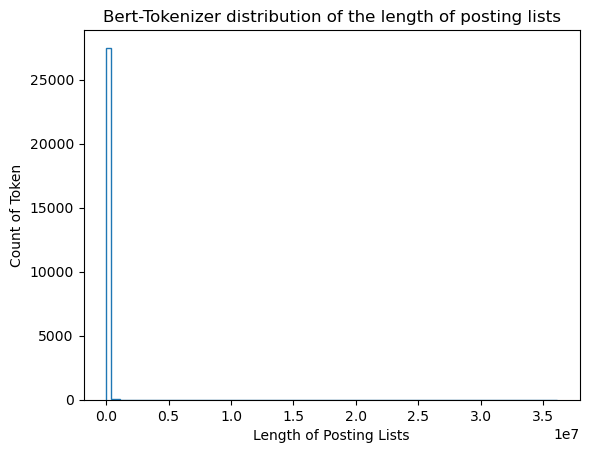

In [351]:
plt.title(r'Bert-Tokenizer distribution of the length of posting lists')
plt.xlabel('Length of Posting Lists')
plt.ylabel('Count of Token')
plt.hist(count_ii.values(), bins=100, histtype='step');

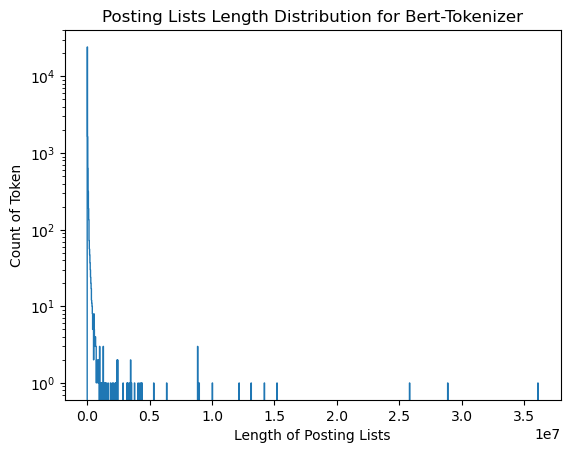

In [374]:
plt.title(r'Posting Lists Length Distribution for Bert-Tokenizer')
plt.xlabel('Length of Posting Lists')
plt.ylabel('Count of Token')
plt.hist(count_ii.values(), bins=1500, histtype='step', log=True);

### ColBERT Representation

In [22]:
batches = collection.enumerate_batches(rank=config.rank)

In [12]:
collection_encoder = CollectionEncoder(config, checkpoint)

In [ ]:
embs_counter = Counter()
doclens_counter = Counter()
for chunk_idx, offset, passages in tqdm(batches, disable=config.rank > 0):
    embs, doclens = collection_encoder.encode_passages(passages)
    print("\rupdating len ", end='')
    doclens_counter.update(doclens)
    print("\rupdating emb ", end='')
    embs_counter.update(list(embs.flatten().detach().numpy().astype('float32').round(6)))
    print(f"\r{chunk_idx}: {len(embs_counter)} {len(doclens_counter)} {' '*10}")

0it [00:00, ?it/s]

[Oct 24, 14:11:26] [0] 		 #> Encoding 25000 passages..
updating emb 0: 19688 184
[Oct 24, 14:12:40] [0] 		 #> Encoding 25000 passages..
updating emb 1: 19790 191
[Oct 24, 14:13:55] [0] 		 #> Encoding 25000 passages..
updating emb 2: 19823 196
[Oct 24, 14:15:10] [0] 		 #> Encoding 25000 passages..
updating emb 3: 19866 197
[Oct 24, 14:16:26] [0] 		 #> Encoding 25000 passages..
updating emb 4: 19889 198
[Oct 24, 14:17:41] [0] 		 #> Encoding 25000 passages..
updating emb 5: 19903 200
[Oct 24, 14:18:55] [0] 		 #> Encoding 25000 passages..
updating emb 6: 19927 200
[Oct 24, 14:20:08] [0] 		 #> Encoding 25000 passages..
updating emb 7: 19937 201
[Oct 24, 14:21:21] [0] 		 #> Encoding 25000 passages..
updating emb 8: 19950 201
[Oct 24, 14:22:33] [0] 		 #> Encoding 25000 passages..
updating emb 9: 19954 201
[Oct 24, 14:23:46] [0] 		 #> Encoding 25000 passages..
updating emb 10: 19964 202
[Oct 24, 14:25:01] [0] 		 #> Encoding 25000 passages..
updating emb 11: 19988 203
[Oct 24, 14:26:14] [0] 		 

In [48]:
import ujson
index_file = '../data/ColBERT_v1_dense_count.json'
with open(index_file, 'w') as f:
    ujson.dump(dict(embs_counter), f)

In [30]:
avg_doclen = np.average(list(doclens_counter.keys()), weights=list(doclens_counter.values()))
avg_doclen

67.60597786225759

In [51]:
sorted_doclens = sorted(doclens_counter.items())
sorted_doclens = np.array(sorted_doclens)

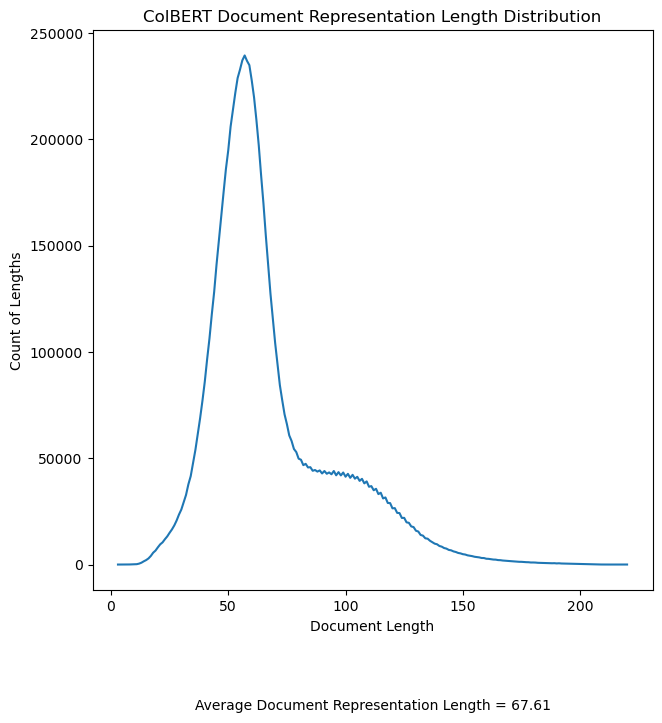

In [66]:
hist_x = 'Document Length'
hist_y = 'Count of Lengths'

additional_text = f"Average Document Representation Length = {avg_doclen:.2f}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Document Representation Length Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
plt.plot(sorted_doclens[:,0], sorted_doclens[:,1])
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

In [ ]:
sorted_dr = sorted(embs_counter.items())
sorted_dr = np.array(sorted_dr)

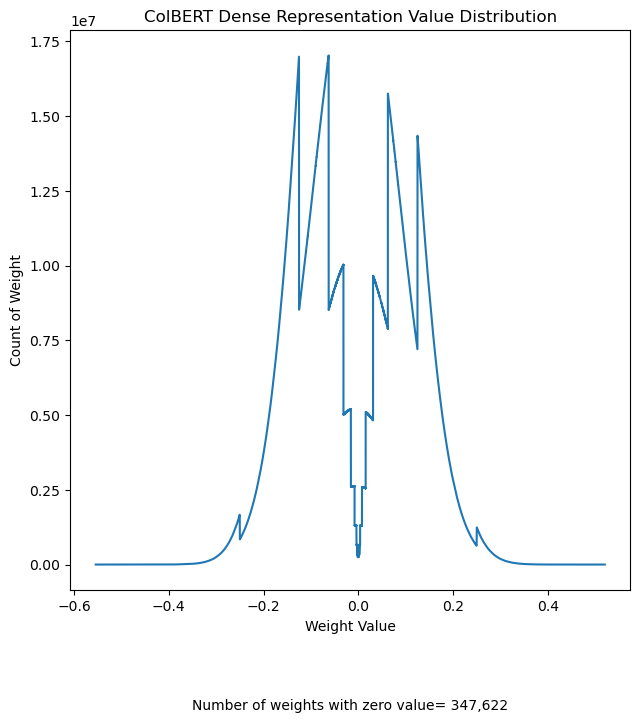

In [67]:
hist_x = 'Weight Value'
hist_y = 'Count of Weight'

additional_text = f"Number of weights with zero value= {embs_counter[0]:3,}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Dense Representation Value Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
plt.plot(sorted_dr[:,0], sorted_dr[:,1])
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

### Get Model Weights

In [36]:
from collections import defaultdict

In [39]:
model_weights = defaultdict(list)
for name, param in tqdm(model.named_parameters()):
    if not name.endswith('weight') \
        or 'LayerNorm' in name \
        or name.startswith('model.bert.embeddings') \
        or name.startswith('model.bert.pooler'): 
            continue
    s_name = name.split('.')
    if s_name[1] == 'bert':
        clean_name = ".".join(s_name[5:])
    else:
        clean_name = ".".join(s_name[1:])
    # print(clean_name, ":" ,param.shape)
    model_weights[clean_name] += param.round(decimals=6).cpu().detach().numpy().flatten().tolist()

200it [00:02, 97.90it/s] 


In [41]:
import matplotlib.pyplot as plt

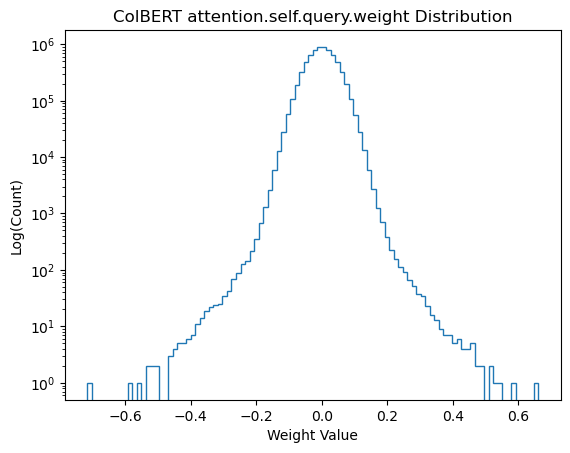

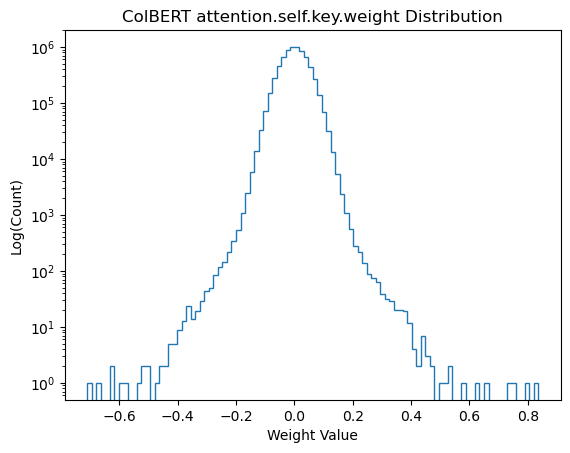

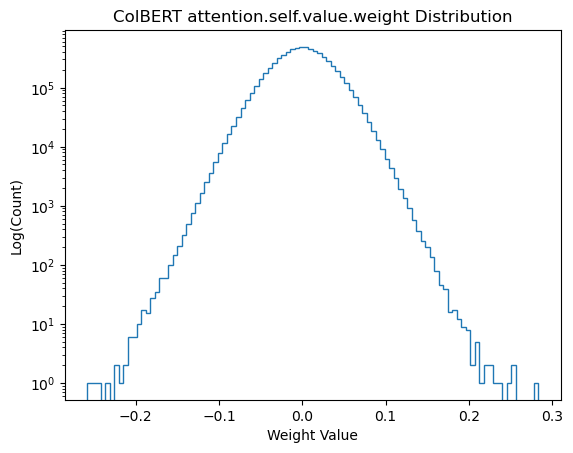

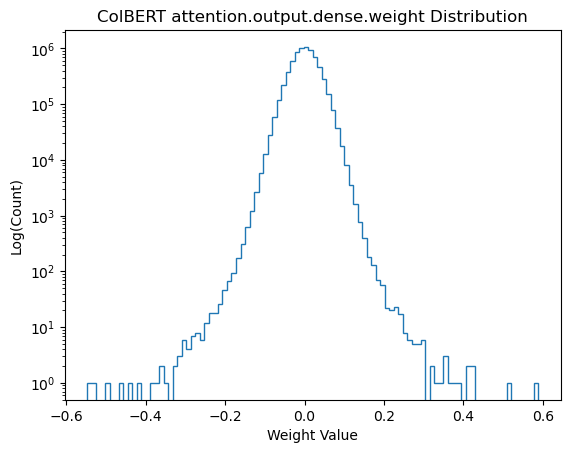

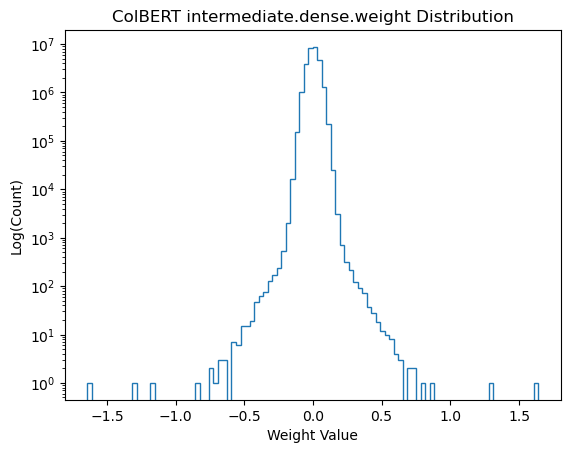

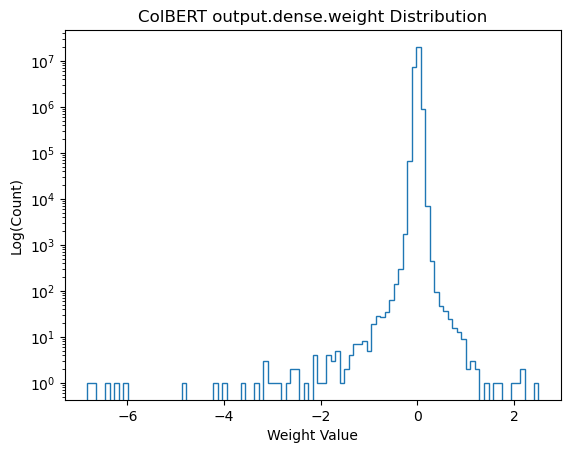

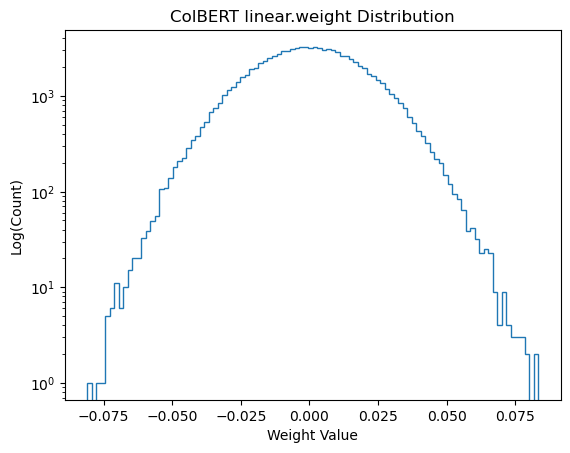

In [42]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'
for name, weights in model_weights.items():
    plt.title(f'ColBERT {name} Distribution')
    
    plt.xlabel(f'{hist_x}')
    
    ylabel = f'Log({hist_y})' if use_hist_log else f'{hist_y}'
    plt.ylabel(ylabel)
    plt.hist(weights, bins=100, histtype='step', log=True);
    plt.show()

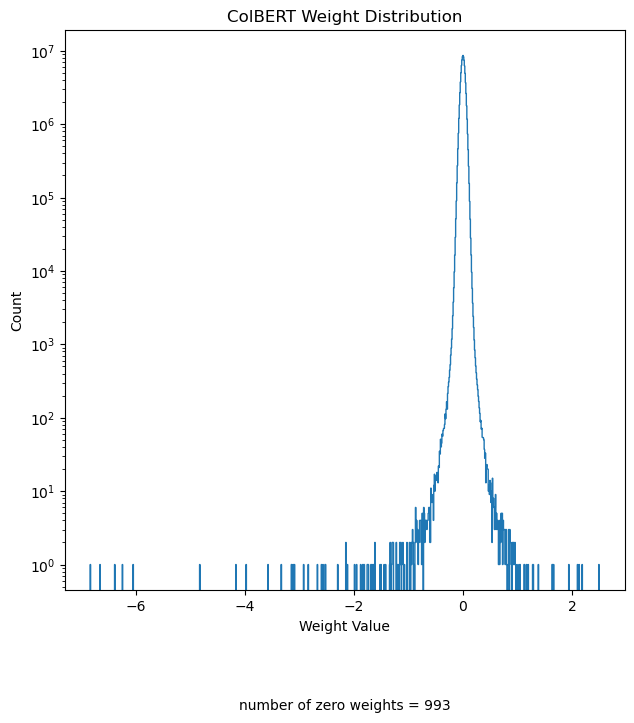

In [43]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'

all_weights = []
for name, weights in model_weights.items():
    all_weights += weights


additional_text = f"number of zero weights = {(np.array(all_weights)==0).sum()}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Weight Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
ax1.hist(all_weights, bins=1000, histtype='step', log=True);
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

#### Prev

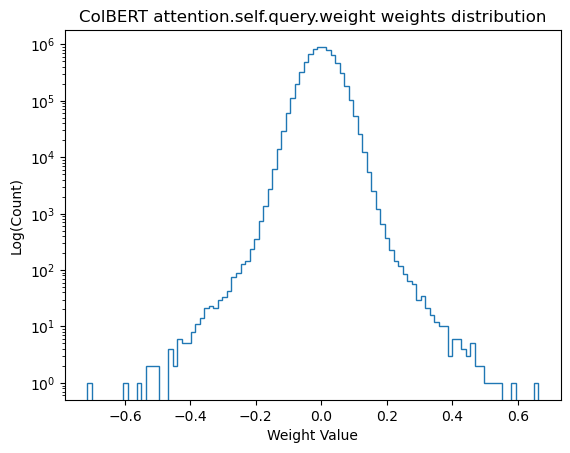

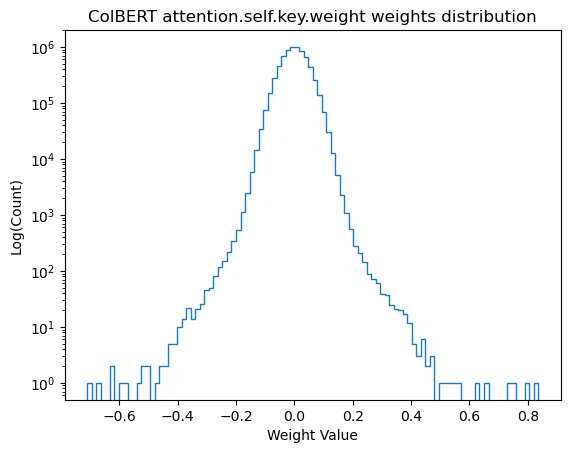

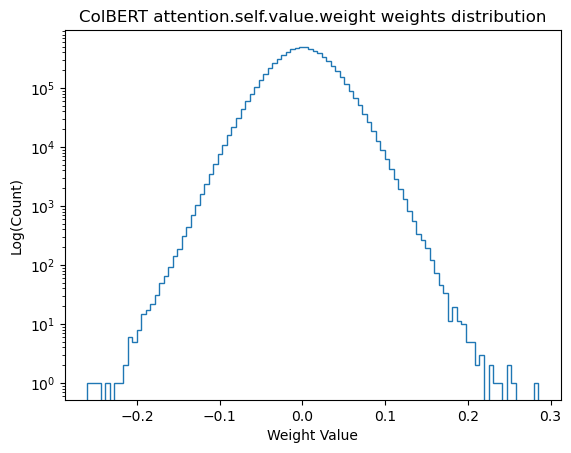

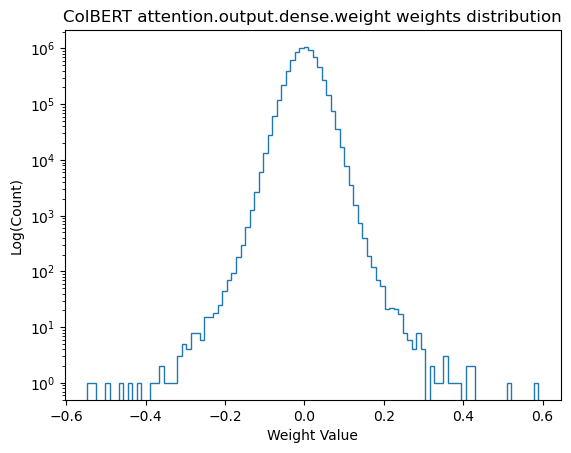

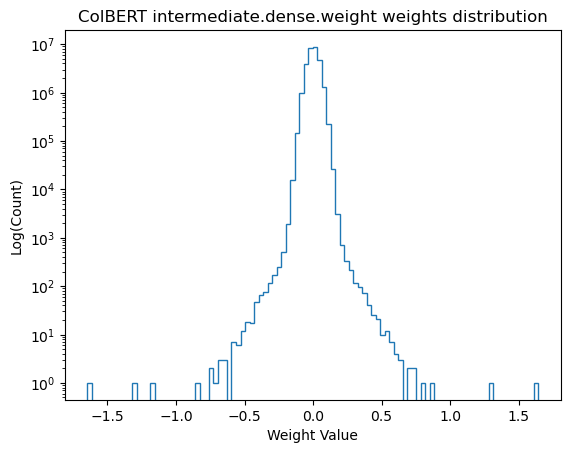

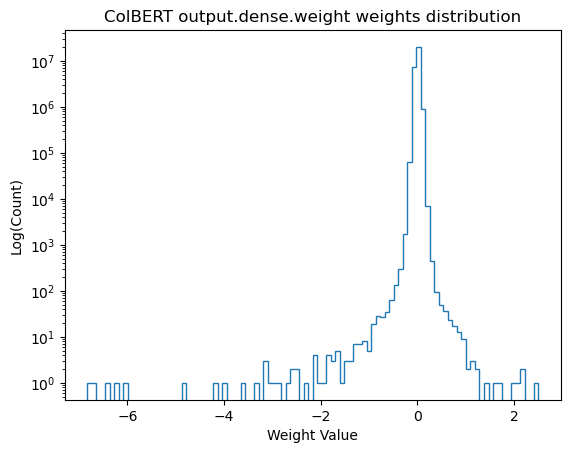

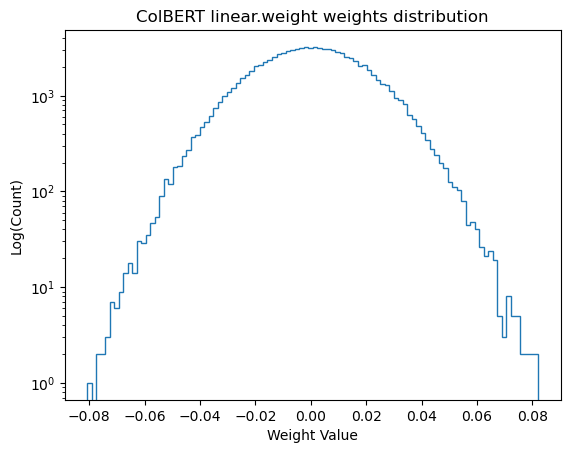

In [326]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'
for name, weights in model_weights.items():
    plt.title(f'ColBERT {name} Distribution')
    
    plt.xlabel(f'{hist_x}')
    
    ylabel = f'Log({hist_y})' if use_hist_log else f'{hist_y}'
    plt.ylabel(ylabel)
    plt.hist(weights, bins=100, histtype='step', log=True);
    plt.show()

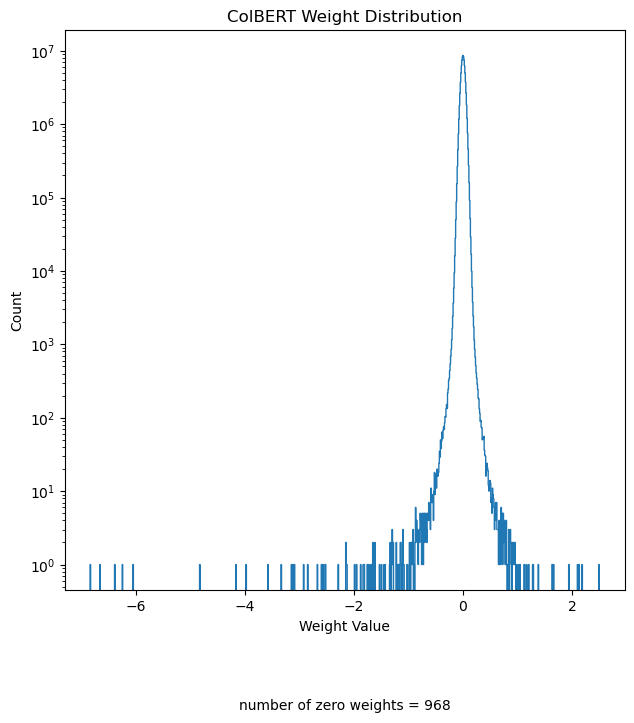

In [384]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'

all_weights = []
for name, weights in model_weights.items():
    all_weights += weights


additional_text = f"number of zero weights = {(np.array(all_weights)==0).sum()}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Weight Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
ax1.hist(all_weights, bins=1000, histtype='step', log=True);
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

### Get Residual Values

In [21]:
codes = searcher.ranker.embeddings_strided.codes
residuals = searcher.ranker.embeddings_strided.residuals

In [43]:
residuals = residuals.cuda()

In [24]:
codes.shape, codes.dtype, codes.min(), codes.max()

(torch.Size([597760602]),
 torch.int32,
 tensor(0, dtype=torch.int32),
 tensor(262143, dtype=torch.int32))

In [25]:
residuals.shape, residuals.dtype, residuals.min(), residuals.max()

(torch.Size([597760602, 32]),
 torch.uint8,
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

In [44]:
cluster_residuals_counter = {}

for cluster_id in tqdm(range(262144)):
    cluster_chunk_idx = searcher.ranker.embeddings_strided.codes == cluster_id
    unique_cluster, unique_counts = searcher.ranker.embeddings_strided.residuals[cluster_chunk_idx].flatten().unique(return_counts=True)
    cluster_residuals_counter[cluster_id] = dict(zip(unique_cluster.tolist(), unique_counts.tolist()))

  0%|          | 0/262144 [00:00<?, ?it/s]

In [62]:
len(cluster_residuals_counter.keys())

262144

In [83]:
from collections import defaultdict

In [87]:
import json
with open('cluster_residuals.json', 'r') as file:
    cluster_residuals_counter = json.load(file)

In [93]:
flat_res = defaultdict(int)

In [94]:
for cluster_id, cluster_res in cluster_residuals_counter.items():
    for res_val, res_count in cluster_res.items():
        flat_res[int(res_val)] += res_count

In [96]:
import matplotlib.pyplot as plt

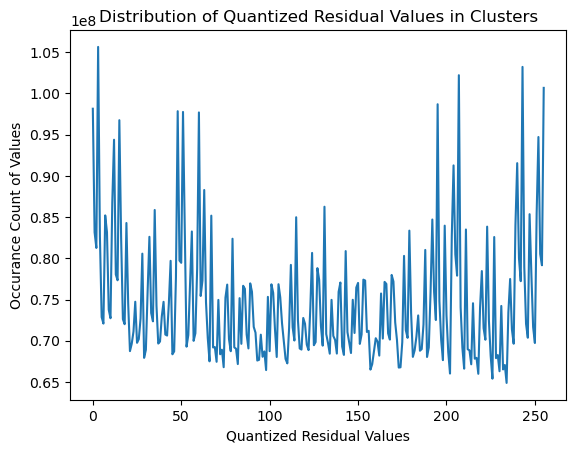

In [104]:
plt.title('Distribution of Quantized Residual Values in Clusters')
plt.xlabel('Quantized Residual Values')
plt.ylabel('Occurance Count of Values') 
plt.plot(flat_res.keys(), flat_res.values())
plt.show()

# Adjust MS-MACRO full id tsv to json

In [1]:
id_tsv = r'../data/triples.train.full.id.tsv'
id_json = r'../data/triples.train.full.id.json'

In [4]:
num_rec = 397768673
with open (id_tsv, 'r') as f:
    with open(id_json,'w') as w:
        for i, l in enumerate(f):
            l = l.strip().split('\t')
            ujson.dump(list(map(int,l)), w)
            w.write('\n')
            if i % 100000 == 0:
                print(f"{i/num_rec}:4f")

# New Section

# Adjust MS-MARCO

In [2]:
from colbert.evaluation.loaders import *

In [3]:
from tqdm.auto import tqdm

In [15]:
param = {
    'triples': '../data/triples.train.small.tsv',
    'queries': '../data/queries.train.tsv',
    'collection': '../data/collection.tsv'
}

In [ ]:
def load_queries(queries_path):
    queries = OrderedDict()

    print_message("#> Loading the queries from", queries_path, "...")

    with open(queries_path, encoding='utf-8') as f:
        for line in f:
            qid, query, *_ = line.replace("\xa0", " ").strip().split('\t')
            qid = int(qid)

            assert (qid not in queries), ("Query QID", qid, "is repeated!")
            queries[re.sub('[^ 0-9a-zA-Z_-]', '', query.strip(" "))] = qid

    print_message("#> Got", len(queries), "queries. All QIDs are unique.\n")

    return queries

In [ ]:
def load_collection(collection_path):
    print_message("#> Loading collection...")

    collection = {}

    with open(collection_path, encoding="utf-8") as f:
        for line_idx, line in enumerate(f):
            if line_idx % (1000*1000) == 0:
                print(f'{line_idx // 1000 // 1000}M', end=' ', flush=True)

            pid, passage, *rest = line.strip('\n\r ').split('\t')
            assert pid == 'id' or int(pid) == line_idx

            if len(rest) >= 1:
                title = rest[0]
                passage = title + ' | ' + passage

            collection[passage] = line_idx

    print()

    return collection

In [ ]:
import re

In [ ]:
queries = load_queries(param['queries'])

[Sep 26, 18:41:38] #> Loading the queries from ../data/queries.train.tsv ...
[Sep 26, 18:41:39] #> Got 806349 queries. All QIDs are unique.



In [ ]:
collection = load_collection(param['collection'])

[Sep 26, 18:41:39] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 


In [ ]:
global err_text
err_text = ""
def get_id(text, data):
    err_text = text
    _id = data.get(exceptions.get(text, text), None)
    if _id is None: 
        text = text.replace("\xa0",' ')
        _id = data.get(exceptions.get(text, text), None)
    if _id is None: 
        n_text = text.strip(' ')
        _id = data.get(exceptions.get(n_text, n_text), None)
    if _id is None: 
        n_text = re.sub('[^ 0-9a-zA-Z_-]', '', n_text)
        _id = data.get(exceptions.get(n_text, n_text), None)
    if _id is None: 
        _id = data.get(text.strip(' '), None)
    
    if _id is None:
        print(text)
        raise Exception(text)
    return _id

In [ ]:
exceptions = {'divorce et sÃ©paration': 'divorce et séparation',
 'what is intelÂ® vpro technology': 'what is intel® vpro technology',
 'what is aÂ\xa0shock wave': 'what is a shock wave',
 'Germanyâ\x80\x99s perspective, the Treaty of Versailles was a fair settlement for its national interests': 'Germany’s perspective, the Treaty of Versailles was a fair settlement for its national interests',
 'yesÃ¼n temÃ¼r khan emperor taiding of yuan': 'yesün temür khan emperor taiding of yuan',
 ' The vitamin that prevents beriberi is ': ' The vitamin that prevents beriberi is',
 ' phosphates as food ingredients ': ' phosphates as food ingredients',
 ' who invented the periodic table ': ' who invented the periodic table',
 'what does bokmÃ¥l mean': 'what does bokmål mean',
 'which action should youÂ\xa0never take when selecting quotations': 'which action should you never take when selecting quotations',
 'dermatitis, anemia, convulsions, depressions, and confusion are all signs of a vitamin _________Â\xa0deficiency.': 'dermatitis anemia convulsions depressions and confusion are all signs of a vitamin _________ deficiency',
 ' In humans, the normal set point for body temperature is ': 'In humans the normal set point for body temperature is',
 'what did you notice about the relationship between pressure and volume when the temperatureÂ\xa0 is held constant?': 'what did you notice about the relationship between pressure and volume when the temperature  is held constant',
 'the Â\xa0____________Â\xa0 that vibrates like a drum when sound waves hit.': 'the  ____________  that vibrates like a drum when sound waves hit',
 'what is composition?Â\xa0 why is composition important?': 'what is composition  why is composition important',
 'the lithosphere consists of Â\xa0____________': 'the lithosphere consists of  ____________',
 "what is a 'cost engineer ": 'what is a cost engineer',
 'A simple way to save with a competitive interest rate. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. Just deposit your savings and watch it grow. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. ': 'A simple way to save with a competitive interest rate. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. Just deposit your savings and watch it grow. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0.',
 "Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir ": "Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir",
 "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir ": "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir"}

In [ ]:
examples = []
with open(param['triples'], encoding='utf-8') as f:
    for line in tqdm(f):
        q_str, p_str_p, p_str_n = line.strip('\n').split('\t')
        qid = get_id(q_str, queries)
        pid_p = get_id(p_str_p, collection)
        pid_n = get_id(p_str_n, collection)
        example = [qid, pid_p, pid_n]
        examples.append(example)

0it [00:00, ?it/s]

In [ ]:
id_file = '../data/triples.train.small.id.json'
    
with open(id_file, 'w') as f:
    for example in examples:
        ujson.dump(example, f)
        f.write('\n')

output_path = f.name
print_message(f"#> Saved examples with {len(self.data)} lines to {f.name}")

NameError: name 'self' is not defined

In [ ]:
id_file = '../data/triples.train.small.id.tsv'
with open(id_file, 'r') as f:
    id_examples = ujson.load(f)

In [ ]:
len(id_examples)
len(id_examples[0])

In [ ]:
data = collection
# data = queries
qid = [k for k in data.keys() if "lamic Laws are made up of Shar" in k]
qid

["Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir",
 "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø

In [304]:
exceptions = {**exceptions, **{p_str_n: qid[1]}}
exceptions

{'divorce et sÃ©paration': 'divorce et séparation',
 'what is intelÂ® vpro technology': 'what is intel® vpro technology',
 'what is aÂ\xa0shock wave': 'what is a shock wave',
 'Germanyâ\x80\x99s perspective, the Treaty of Versailles was a fair settlement for its national interests': 'Germany’s perspective, the Treaty of Versailles was a fair settlement for its national interests',
 'yesÃ¼n temÃ¼r khan emperor taiding of yuan': 'yesün temür khan emperor taiding of yuan',
 ' The vitamin that prevents beriberi is ': ' The vitamin that prevents beriberi is',
 ' phosphates as food ingredients ': ' phosphates as food ingredients',
 ' who invented the periodic table ': ' who invented the periodic table',
 'what does bokmÃ¥l mean': 'what does bokmål mean',
 'which action should youÂ\xa0never take when selecting quotations': 'which action should you never take when selecting quotations',
 'dermatitis, anemia, convulsions, depressions, and confusion are all signs of a vitamin _________Â\xa0defic